In order to run this notebook:
* clone the corpus: `git clone --recurse-submodules -j8 git@github.com:DCMLab/romantic_piano_corpus.git`
* create new environment, make it visible to your Jupyter
  * for conda do `conda create --name {name} python=3.10`
  * activate it and install `pip install ipykernel`
  * `ipython kernel install --user --name={name}`
* within the new environment, install requirements, e.g. `pip install -r requirements.txt`
  * this currently involves installing ms3 and dimcat from their `development` branches
* head into the clone of romantic_piano_corpus and run `ms3 extract -X -M -N`
* Set the `corpus_path` in the second cell to your local clone.

If the plots are not displayed and you are in JupyterLab, use [this guide](https://plotly.com/python/getting-started/#jupyterlab-support).

In [1]:
%load_ext autoreload
%autoreload 2
import os
from fractions import Fraction
from IPython.display import HTML
from ms3 import __version__ as ms3_version
from ms3 import fifths2iv, resolve_relative_keys, map_dict
from dimcat import (
    Corpus,  
    Pipeline,
    IsAnnotatedFilter,
    CorpusGrouper, 
    PieceGrouper, 
    ModeGrouper, 
    ChordFeatureSlicer,
    ChordSymbolBigrams, 
    ChordSymbolUnigrams,
    LocalKeySlicer,
    PhraseSlicer
)
from dimcat import __version__ as dimcat_version
from git import Repo
import plotly.express as px
import plotly.graph_objects as go
import colorlover
from plotly.subplots import make_subplots
import pandas as pd
pd.set_option("display.max_columns", 100)

In [2]:
corpus_path = "~/romantic_piano_corpus"
repo = Repo(corpus_path)
print(f"{os.path.basename(corpus_path)} @ {repo.commit().hexsha[:7]}")
print(f"dimcat version {dimcat_version}")
print(f"ms3 version {ms3_version}")

romantic_piano_corpus @ 327b541
dimcat version 0.2.0.post1.dev35+g9830b67
ms3 version 0.5.3.post0.dev88+g764fcd4.dirty


In [3]:
STD_LAYOUT = {
 'paper_bgcolor': '#FFFFFF',
 'plot_bgcolor': '#FFFFFF',
 'margin': {'l': 40, 'r': 0, 'b': 0, 't': 40, 'pad': 0},
 'font': {'size': 15}
}
OUTPUT_DIR = "/home/hentsche/Documents/phd/romantic_piano_corpus_report/figures/"
#HTML(colorlover.to_html(colorlover.scales))
HTML(colorlover.to_html(colorlover.scales['9']['qual']['Paired']))

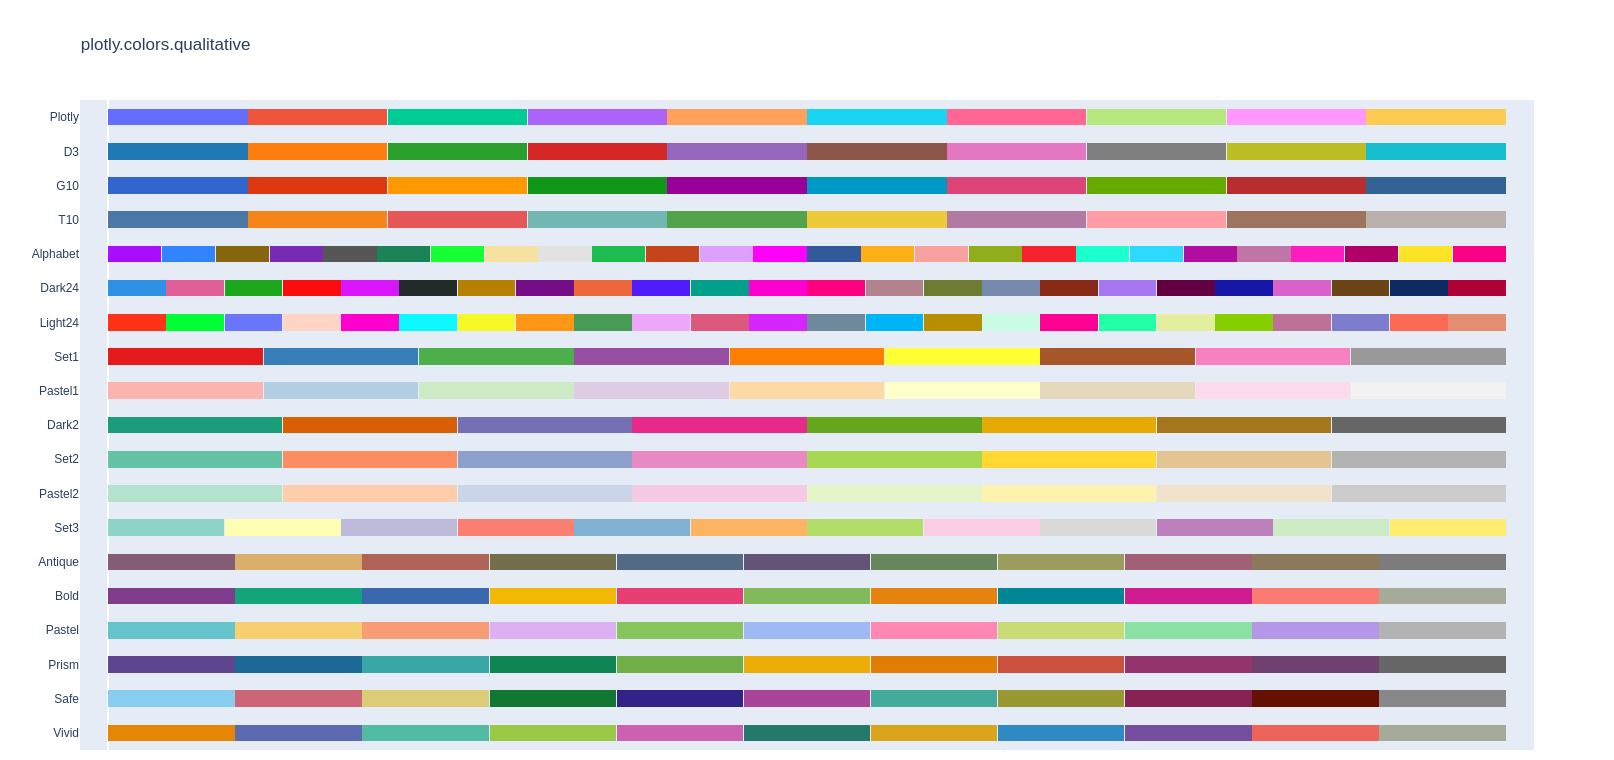

In [4]:
fig = px.colors.qualitative.swatches()
fig.show()

In [5]:
corpus_color_scale = px.colors.qualitative.D3

# Overview

In [6]:
corpus = Corpus()
corpus.load(directory=corpus_path)
corpus.data

1135 files.
KEY                       -> EXTENSIONS
---------------------------------------
beethoven_piano_sonatas   -> {'.mscx': 87, '.tsv': 239}
chopin_mazurkas           -> {'.mscx': 55, '.tsv': 166}
debussy_suite_bergamasque -> {'.mscx': 4, '.tsv': 13}
dvorak_silhouettes        -> {'.mscx': 12, '.tsv': 37}
grieg_lyrical_pieces      -> {'.mscx': 66, '.tsv': 199}
liszt_pelerinage          -> {'.mscx': 19, '.tsv': 58}
medtner_tales             -> {'.mscx': 19, '.tsv': 59}
schumann_kinderszenen     -> {'.mscx': 13, '.tsv': 40}
tchaikovsky_seasons       -> {'.mscx': 12, '.tsv': 37}

None of the 287 score files have been parsed.

All 848 tabular files have been parsed, 264 of them as Annotations object(s).
KEY                       -> ANNOTATION LAYERS
----------------------------------------------
beethoven_piano_sonatas   -> staff  voice  harmony_layer  color  
                          -> 2      1      1 (dcml)       default    20740
                          ->        2      1 (dcml

## Metadata

In [7]:
all_metadata = corpus.data.metadata(from_tsv=True)
print(f"Concatenated 'metadata.tsv' files cover {len(all_metadata)} of the {len(corpus.data._score_ids())} scores.")
all_metadata.groupby(level=0).nth(0)

Concatenated 'metadata.tsv' files cover 287 of the 287 scores.


rel_paths                             fnames  \
key                                                                      
beethoven_piano_sonatas         MS3                               01-1   
chopin_mazurkas                 MS3                      BI105-2op30-2   
debussy_suite_bergamasque       MS3              l075-01_suite_prelude   
dvorak_silhouettes              MS3                            op08n01   
grieg_lyrical_pieces            MS3                            op12n01   
liszt_pelerinage                MS3  160.01_Chapelle_de_Guillaume_Tell   
medtner_tales                   MS3                            op08n01   
schumann_kinderszenen           MS3                                n01   
tchaikovsky_seasons             MS3                            op37a01   

                           last_mc  last_mn  length_qb  length_qb_unfolded  \
key                                                                          
beethoven_piano_sonatas        154      152      608.0              1216.0   
chopin_mazurkas                 65       64      193.0               193.0   
debussy_suite_bergamasque       89       89      356.0               356.0   
dvorak_silhouettes              54       52      156.5               156.5   
grieg_lyrical_pieces            23       23       46.0                46.0   
liszt_pelerinage                97       97      388.0               388.0   
medtner_tales                   81       81      162.0               162.0   
schumann_kinderszenen           22       22       44.0                88.0   
tchaikovsky_seasons            103      103      309.0               309.0   

                           all_notes_qb  n_onsets  n_onset_positions TimeSig  \
key                                                                            
beethoven_piano_sonatas         1476.00      1679                985  1: 2/2   
chopin_mazurkas                  711.00       810                274  1: 3/4   
debussy_suite_bergamasque       1533.67      1721                870  1: 4/4   
dvorak_silhouettes               658.75       957                288  1: 6/8   
grieg_lyrical_pieces             135.50       268                156  1: 2/4   
liszt_pelerinage                1902.42      2879               1069  1: 4/4   
medtner_tales                    603.00      1481                528  1: 4/8   
schumann_kinderszenen            134.33       241                141  1: 2/4   
tchaikovsky_seasons             1058.17      1537                829  1: 3/4   

                                       KeySig  label_count annotated_key  \
key                                                                        
beethoven_piano_sonatas                 1: -4          241             f   
chopin_mazurkas                          1: 2          116             b   
debussy_suite_bergamasque               1: -1          274             F   
dvorak_silhouettes         1: 4, 7: -5, 49: 4           80            c#   
grieg_lyrical_pieces                    1: -3           43            Eb   
liszt_pelerinage                         1: 0          174             C   
medtner_tales                           1: -3          213             c   
schumann_kinderszenen                    1: 1           44             G   
tchaikovsky_seasons        1: 3, 29: 1, 63: 3          313             A   

                                                                  annotators  \
key                                                                            
beethoven_piano_sonatas         Lars & Ya-Chuan (2.2.0), John Heilig (2.3.0)   
chopin_mazurkas            Wendelin Bitzan (1.0.0), Adrian Nagel (2.2.0),...   
debussy_suite_bergamasque          Adrian Nagel (2.1.1), Amelia Brey (2.3.0)   
dvorak_silhouettes                Daniel Grote (2.1.1), Hanné Becker (2.3.0)   
grieg_lyrical_pieces                Adrian Nagel (2.1.1), John Heilig (2.30)   
liszt_pelerinage                   Adrian Nagel (2.1.1), Amelia Brey (2.3.

In [8]:
print("VALUE COUNTS OF THE COLUMN 'annotators'")
all_metadata.annotators.value_counts()

VALUE COUNTS OF THE COLUMN 'annotators'


Adrian Nagel (2.1.1), John Heilig (2.3.0)                               75
Wendelin Bitzan (1.0.0), Adrian Nagel (2.2.0), Davor Krkljus (2.3.0)    49
Adrian Nagel (2.3.0)                                                    16
Adrian Nagel (2.1.1), Amelia Brey (2.3.0)                               15
Wendelin Bitzan (2.2.0), John Heilig (2.3.0)                            15
Tal Soker (2.1.1), John Heilig (2.3.0)                                  13
Lydia Carlisi (2.2.0), Adrian Nagel (2.3.0)                             11
Adrian Nagel (2.1.1), Hanné Becker (2.3.0)                               9
Adrian Nagel                                                             8
Adrian Nagel (2.2.0), Amelia Brey (2.3.0)                                6
Daniel Grote (2.2.0), Adrian Nagel (2.3.0)                               6
Adrian Nagel (2.2.0), Hanné Becker (2.3.0)                               5
Wendelin Bitzan                                                          5
Lydia Carlisi (2.2.0), Vi

In [9]:
print(f"Composition dates range from {all_metadata.composed_start.min()} ({all_metadata.loc[all_metadata.composed_start.idxmin(), 'fnames']}) "
      f"to {all_metadata.composed_end.max()} ({all_metadata.loc[all_metadata.composed_end.idxmax(), 'fnames']}).")

Composition dates range from 1794 (01-1) to 1925 (op08n01).


In [10]:
annotated = IsAnnotatedFilter().process_data(corpus)
print(f"Before: {len(corpus.indices[()])} IDs, after filtering: {len(annotated.indices[()])}")

Before: 287 IDs, after filtering: 264


**Choose here if you want to see stats for all or only for annotated scores.**

In [11]:
#selected = corpus
selected = annotated

## Measures

In [12]:
all_measures = selected.get_facet('measures')
print(f"{len(all_measures.index)} measures over {len(all_measures.groupby(level=[0,1]))} files.")
all_measures.head()

29956 measures over 264 files.


mc  mn quarterbeats  duration_qb  \
corpus                  fname interval                                         
beethoven_piano_sonatas 01-1  [0.0, 1.0)     1   0            0          1.0   
                              [1.0, 5.0)     2   1            1          4.0   
                              [5.0, 9.0)     3   2            5          4.0   
                              [9.0, 13.0)    4   3            9          4.0   
                              [13.0, 17.0)   5   4           13          4.0   

                                            keysig timesig act_dur mc_offset  \
corpus                  fname interval                                         
beethoven_piano_sonatas 01-1  [0.0, 1.0)        -4     2/2     1/4       3/4   
                              [1.0, 5.0)        -4     2/2       1         0   
                              [5.0, 9.0)        -4     2/2       1         0   
                              [9.0, 13.0)       -4     2/2       1         0   
                              [13.0, 17.0)      -4     2/2       1         0   

                                            numbering_offset  dont_count  \
corpus                  fname interval                                     
beethoven_piano_sonatas 01-1  [0.0, 1.0)                <NA>           1   
                              [1.0, 5.0)                <NA>        <NA>   
                              [5.0, 9.0)                <NA>        <NA>   
                              [9.0, 13.0)               <NA>        <NA>   
                              [13.0, 17.0)              <NA>        <NA>   

                                           barline breaks       repeats  next  \
corpus                  fname interval                                          
beethoven_piano_sonatas 01-1  [0.0, 1.0)       NaN    NaN  firstMeasure  (2,)   
                              [1.0, 5.0)       NaN    NaN           NaN  (3,)   
                              [5.0, 9.0)       NaN    NaN           NaN  (4,)   
                              [9.0, 13.0)      NaN    NaN           NaN  (5,)   
                              [13.0, 17.0)     NaN    NaN           NaN  (6,)   

                                           markers jump_bwd jump_fwd  \
corpus                  fname interval                                 
beethoven_piano_sonatas 01-1  [0.0, 1.0)       NaN      NaN      NaN   
                              [1.0, 5.0)       NaN      NaN      NaN   
                              [5.0, 9.0)       NaN      NaN      NaN   
                              [9.0, 13.0)      NaN      NaN      NaN   
                              [13.0, 17.0)     NaN      NaN      NaN   

                                           play_until  \
corpus                  fname interval                  
beethoven_piano_sonatas 01-1  [0.0, 1.0)          NaN   
                              [1.0, 5.0)          NaN   
                              [5.0, 9.0)          NaN   
                              [9.0, 13.0)         NaN   
                              [13.0, 17.0)        NaN   

                                           quarterbeats_all_endings  volta  
corpus                  fname interval                                      
beethoven_piano_sonatas 01-1  [0.0, 1.0)                        NaN   <NA>  
                              [1.0, 5.0)                        NaN   <NA>  
                              [5.0, 9.0)                        NaN   <NA>  
                              [9.0, 13.0)                       NaN   <NA>  
                              [13.0, 17.0)                      NaN   <NA>

In [13]:
print("Distribution of time signatures per XML measure (MC):")
all_measures.timesig.value_counts(dropna=False)

Distribution of time signatures per XML measure (MC):


3/4      10130
2/4       6073
4/4       5186
6/8       3432
2/2       2523
3/8       1278
12/8       351
9/8        304
6/4        283
9/16       148
4/8         81
2/8         75
12/16       43
12/32       17
6/16        17
17/4         3
33/32        2
15/4         1
14/4         1
10/4         1
10/8         1
12/4         1
7/4          1
5/4          1
3/2          1
11/4         1
18/4         1
Name: timesig, dtype: int64

## Notes

In [14]:
all_notes = selected.get_facet('notes')
print(f"{len(all_notes.index)} notes over {len(all_notes.groupby(level=[0,1]))} files.")
all_notes.head()

434219 notes over 264 files.


quarterbeats  duration_qb  mc  mn  \
corpus                  fname interval                                       
beethoven_piano_sonatas 01-1  [0.0, 1.0)            0          1.0   1   0   
                              [1.0, 2.0)            1          1.0   2   1   
                              [2.0, 3.0)            2          1.0   2   1   
                              [3.0, 4.0)            3          1.0   2   1   
                              [4.0, 5.0)            4          1.0   2   1   

                                         mc_onset mn_onset timesig  staff  \
corpus                  fname interval                                      
beethoven_piano_sonatas 01-1  [0.0, 1.0)        0      3/4     2/2      1   
                              [1.0, 2.0)        0        0     2/2      1   
                              [2.0, 3.0)      1/4      1/4     2/2      1   
                              [3.0, 4.0)      1/2      1/2     2/2      1   
                              [4.0, 5.0)      3/4      3/4     2/2      1   

                                          voice duration gracenote  \
corpus                  fname interval                               
beethoven_piano_sonatas 01-1  [0.0, 1.0)      1      1/4       NaN   
                              [1.0, 2.0)      1      1/4       NaN   
                              [2.0, 3.0)      1      1/4       NaN   
                              [3.0, 4.0)      1      1/4       NaN   
                              [4.0, 5.0)      1      1/4       NaN   

                                         nominal_duration scalar  tied  tpc  \
corpus                  fname interval                                        
beethoven_piano_sonatas 01-1  [0.0, 1.0)              1/4      1  <NA>    0   
                              [1.0, 2.0)              1/4      1  <NA>   -1   
                              [2.0, 3.0)              1/4      1  <NA>   -4   
                              [3.0, 4.0)              1/4      1  <NA>    0   
                              [4.0, 5.0)              1/4      1  <NA>   -1   

                                          midi  volta  chord_id tremolo  
corpus                  fname interval                                   
beethoven_piano_sonatas 01-1  [0.0, 1.0)    60   <NA>         0     NaN  
                              [1.0, 2.0)    65   <NA>         1     NaN  
                              [2.0, 3.0)    68   <NA>         2     NaN  
                              [3.0, 4.0)    72   <NA>         3     NaN  
                              [4.0, 5.0)    77   <NA>         4     NaN

### Notes and staves

In [15]:
print("Distribution of notes over staves:")
all_notes.staff.value_counts()

Distribution of notes over staves:


1    230221
2    200617
3      2397
4       984
Name: staff, dtype: Int64

In [16]:
print("Distribution of notes over staves for all pieces with more than two staves\n")
for group, df in all_notes.groupby(level=[0,1]):
    if (df.staff > 2).any():
        print(group)
        print(df.staff.value_counts().to_dict())

Distribution of notes over staves for all pieces with more than two staves

('grieg_lyrical_pieces', 'op43n06')
{2: 769, 3: 422, 1: 180}
('liszt_pelerinage', '161.04_Sonetto_47_del_Petrarca')
{1: 1076, 2: 628, 3: 42, 4: 29}
('liszt_pelerinage', '161.07_Apres_une_lecture_du_Dante')
{1: 6638, 2: 5181, 3: 50}
('liszt_pelerinage', '162.01_Gondoliera')
{3: 1745, 4: 955}
('medtner_tales', 'op34n03')
{1: 1219, 2: 816, 3: 89}
('medtner_tales', 'op35n04')
{1: 1678, 2: 1632, 3: 49}


In [17]:
all_notes[all_notes.staff > 2].groupby(level=[0,1]).staff.value_counts()

corpus                fname                              staff
grieg_lyrical_pieces  op43n06                            3         422
liszt_pelerinage      161.04_Sonetto_47_del_Petrarca     3          42
                                                         4          29
                      161.07_Apres_une_lecture_du_Dante  3          50
                      162.01_Gondoliera                  3        1745
                                                         4         955
medtner_tales         op34n03                            3          89
                      op35n04                            3          49
Name: staff, dtype: int64

## Harmony labels

All symbols, independent of the local key (the mode of which changes their semantics).

In [18]:
all_annotations = annotated.get_facet('expanded')
all_annotations.head()

quarterbeats  duration_qb  mc  mn  \
corpus                  fname interval                                         
beethoven_piano_sonatas 01-1  [0.0, 9.0)              0          9.0   1   0   
                              [9.0, 17.0)             9          8.0   4   3   
                              [17.0, 21.0)           17          4.0   6   5   
                              [21.0, 25.0)           21          4.0   7   6   
                              [25.0, 27.0)           25          2.0   8   7   

                                           mc_onset mn_onset timesig  staff  \
corpus                  fname interval                                        
beethoven_piano_sonatas 01-1  [0.0, 9.0)          0      3/4     2/2      2   
                              [9.0, 17.0)         0        0     2/2      2   
                              [17.0, 21.0)        0        0     2/2      2   
                              [21.0, 25.0)        0        0     2/2      2   
                              [25.0, 27.0)        0        0     2/2      2   

                                            voice  volta   label alt_label  \
corpus                  fname interval                                       
beethoven_piano_sonatas 01-1  [0.0, 9.0)        1   <NA>    f.i{       NaN   
                              [9.0, 17.0)       1   <NA>     V65       NaN   
                              [17.0, 21.0)      1   <NA>       i       NaN   
                              [21.0, 25.0)      1   <NA>  #viio6       NaN   
                              [25.0, 27.0)      1   <NA>      i6       NaN   

                                           globalkey localkey pedal   chord  \
corpus                  fname interval                                        
beethoven_piano_sonatas 01-1  [0.0, 9.0)           f        i   NaN       i   
                              [9.0, 17.0)          f        i   NaN     V65   
                              [17.0, 21.0)         f        i   NaN       i   
                              [21.0, 25.0)         f        i   NaN  #viio6   
                              [25.0, 27.0)         f        i   NaN      i6   

                                           special numeral form figbass  \
corpus                  fname interval                                    
beethoven_piano_sonatas 01-1  [0.0, 9.0)       NaN       i  NaN     NaN   
                              [9.0, 17.0)      NaN       V  NaN      65   
                              [17.0, 21.0)     NaN       i  NaN     NaN   
                              [21.0, 25.0)     NaN    #vii    o       6   
                              [25.0, 27.0)     NaN       i  NaN       6   

                                           changes relativeroot cadence  \
corpus                  fname interval                                    
beethoven_piano_sonatas 01-1  [0.0, 9.0)       NaN          NaN     NaN   
                              [9.0, 17.0)      NaN          NaN     NaN   
                              [17.0, 21.0)     NaN          NaN     NaN   
                              [21.0, 25.0)     NaN          NaN     NaN   
                              [25.0, 27.0)     NaN          NaN     NaN   

                                           phraseend chord_type  \
corpus                  fname interval                            
beethoven_piano_sonatas 01-1  [0.0, 9.0)           {          m   
                              [9.0, 17.0)        NaN        Mm7   
                              [17.0, 21.0)       NaN          m   
                              [21.0, 25.0)       NaN          o   
                              [25.0, 27.0)       NaN          m   

                                            globalkey_is_minor  \
corpus                  fname interval                           
beethoven_piano_sonatas 01-1  [0.0, 9.0)                  True   
                              [9.0, 17.0)                 True   
                              [17.0, 21.0

In [19]:
no_chord = all_annotations.root.isna()
print(f"Concatenated annotation tables contains {all_annotations.shape[0]} rows. {no_chord.sum()} of them are not chords. Their values are:")
all_annotations.label[no_chord].value_counts(dropna=False).to_dict()

Concatenated annotation tables contains 57561 rows. 681 of them are not chords. Their values are:


{'{': 640, '}': 32, '|PAC}': 6, '|HC': 2, '|PAC': 1}

In [20]:
all_chords = all_annotations[~no_chord].copy()
print(f"Corpus contains {all_chords.shape[0]} tokens and {len(all_chords.chord.unique())} types over {len(all_chords.groupby(level=[0,1]))} documents.")

Corpus contains 56880 tokens and 3124 types over 264 documents.


In [21]:
#from ms3 import write_tsv
#write_tsv(all_annotations[all_annotations.pedalend.notna()], './issues/pedalpoints.tsv', pre_process=False)

## Corpus summary

In [22]:
summary = all_metadata.set_index('fnames', append=True).reset_index(level=[1,2], drop=True)
if selected == annotated:
    summary = summary[summary.label_count > 0].copy()
summary.index = summary.index.rename(['corpus', 'fname'])
summary.length_qb = all_measures.groupby(level=[0,1]).act_dur.sum() * 4.0
summary = pd.concat([summary,
                     all_notes.groupby(level=[0,1]).size().rename('notes'),
                    ], axis=1)
summary.groupby(level=0).describe().dropna(axis=1, how='all')

last_mc                                        \
                            count        mean         std   min     25%   
corpus                                                                    
beethoven_piano_sonatas      64.0  184.703125   99.997409  28.0  111.25   
chopin_mazurkas              55.0   89.509091   47.668171  20.0   58.50   
debussy_suite_bergamasque     4.0  105.250000   36.270971  72.0   84.75   
dvorak_silhouettes           12.0   56.500000   18.128330  15.0   51.50   
grieg_lyrical_pieces         66.0   82.500000   47.123161  23.0   47.25   
liszt_pelerinage             19.0  138.947368  113.069533  49.0   72.50   
medtner_tales                19.0  130.210526  115.216983  48.0   71.50   
schumann_kinderszenen        13.0   31.230769   12.008010  17.0   24.00   
tchaikovsky_seasons          12.0  104.333333   50.102320  46.0   76.25   

                                                last_mn              \
                             50%     75%    max   count        mean   
corpus                                                                
beethoven_piano_sonatas    169.0  253.50  543.0    64.0  182.218750   
chopin_mazurkas             75.0  112.00  225.0    55.0   92.527273   
debussy_suite_bergamasque   96.5  117.00  156.0     4.0  105.250000   
dvorak_silhouettes          58.5   63.75   81.0    12.0   56.166667   
grieg_lyrical_pieces        72.0   96.75  204.0    66.0   82.030303   
liszt_pelerinage            97.0  148.00  481.0    19.0  138.157895   
medtner_tales               81.0  142.50  554.0    19.0  129.684211   
schumann_kinderszenen       27.0   34.00   58.0    13.0   30.153846   
tchaikovsky_seasons         89.0  119.50  199.0    12.0  104.166667   

                                                                           \
                                  std   min     25%    50%     75%    max   
corpus                                                                      
beethoven_piano_sonatas     99.937674  28.0  108.75  166.5  253.25  543.0   
chopin_mazurkas             55.124054  20.0   56.50   72.0  115.50  247.0   
debussy_suite_bergamasque   36.270971  72.0   84.75   96.5  117.00  156.0   
dvorak_silhouettes          17.928308  15.0   50.00   58.5   63.75   80.0   
grieg_lyrical_pieces        47.118499  23.0   47.25   72.0   95.00  204.0   
liszt_pelerinage           112.514820  48.0   72.50   97.0  146.50  479.0   
medtner_tales              115.060879  47.0   71.00   81.0  141.50  553.0   
schumann_kinderszenen       11.985033  16.0   24.00   25.0   32.00   57.0   
tchaikovsky_seasons         49.963320  46.0   76.25   89.0  119.50  198.0   

                          length_qb_unfolded                                 \
                                       count        mean         std    min   
corpus                                                                        
beethoven_piano_sonatas                 64.0  719.642500  440.937916   84.0   
chopin_mazurkas                         53.0  304.533019  146.421218   35.0   
debussy_suite_bergamasque                4.0  404.000000  147.837749  312.0   
dvorak_silhouettes                      12.0  154.375000   51.041037   63.5   
grieg_lyrical_pieces                    65.0  274.188462  160.953689   46.0   
liszt_pelerinage                        19.0  511.013158  363.761729  120.0   
medtner_tales                           19.0  359.368421  235.116924  130.0   
schumann_kinderszenen                   12.0   94.791667   34.041224   34.0   
tchaikovsky_seasons                     11.0  310.500000  126.055940   92.0   

                                                            all_notes_qb  \
                              25%     50%      75%      max        count   
corpus                                                                     
beethoven_piano_sonatas    365.50  603.50  958.125  1872.00         64.0   
chopin_mazurkas            204.00  289.00  360.000   673.00         55.0   
debussy_suite_berg

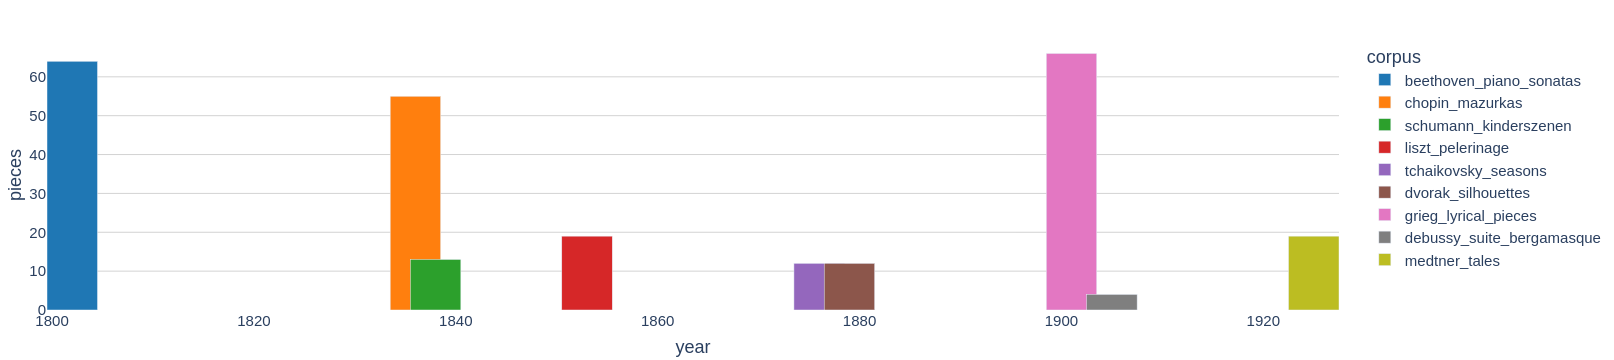

In [23]:
mean_composition_years = summary.groupby(level=0).composed_end.mean().astype(int).sort_values()
chronological_order = mean_composition_years.index.to_list()
corpus_colors = dict(zip(chronological_order, corpus_color_scale))
bar_data = pd.concat([mean_composition_years.rename('year'), 
                      summary.groupby(level='corpus').size().rename('pieces')],
                     axis=1
                    ).reset_index()
fig = px.bar(bar_data, x='year', y='pieces', color='corpus',
             color_discrete_map=corpus_colors,
            height=350, width=800,
            )
fig.update_traces(width=5)
fig.update_layout(**STD_LAYOUT)
fig.update_yaxes(gridcolor='lightgrey')
fig.write_image(os.path.join(OUTPUT_DIR, "corpus_sizes.png"), scale=2)
fig.update_traces(width=5)

In [24]:
corpus_names = dict(
    beethoven_piano_sonatas='Beethoven Sonatas',
    chopin_mazurkas='Chopin Mazurkas',
    debussy_suite_bergamasque='Debussy Suite',
    dvorak_silhouettes="Dvořák Silhouettes",
    grieg_lyrical_pieces="Grieg Lyrical Pieces",
    liszt_pelerinage="Liszt Années",
    medtner_tales="Medtner Tales",
    schumann_kinderszenen="Schumann Kinderszenen",
    tchaikovsky_seasons="Tchaikovsky Seasons"
)
chronological_corpus_names = [corpus_names[corp] for corp in chronological_order]
corpus_name_colors = {corpus_names[corp]: color for corp, color in corpus_colors.items()}
all_annotations['corpus_name'] = all_annotations.index.get_level_values(0).map(corpus_names)
all_chords['corpus_name'] = all_chords.index.get_level_values(0).map(corpus_names)

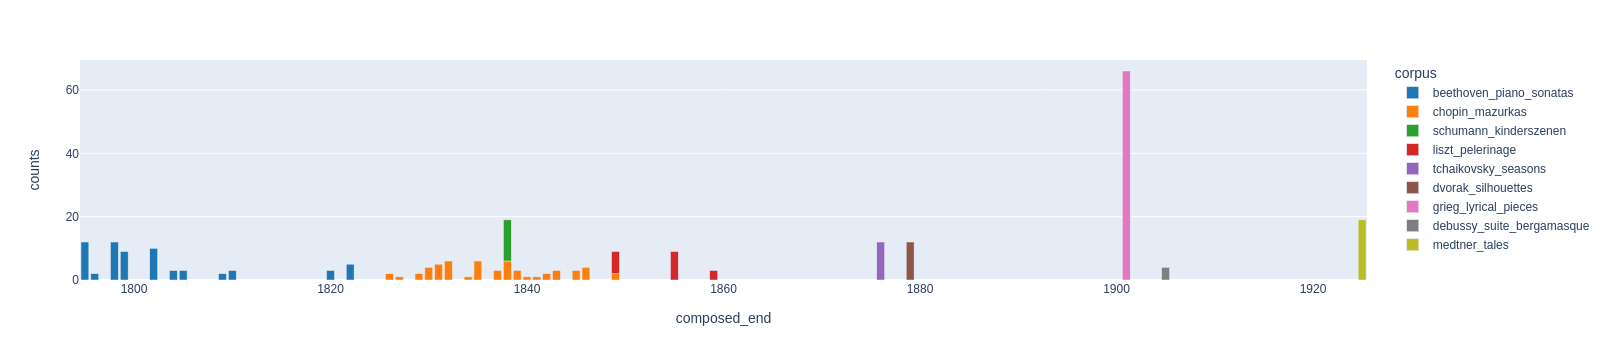

In [25]:
bar_data = summary.reset_index().groupby(['composed_end', 'corpus']).size().rename('counts').reset_index()
px.bar(bar_data, x='composed_end', y='counts', color='corpus', color_discrete_map=corpus_colors)

In [26]:
hist_data = summary.reset_index()
hist_data.corpus = hist_data.corpus.map(corpus_names)
hist_data.head()

corpus fname rel_paths  last_mc  last_mn length_qb  \
0  Beethoven Sonatas  01-1       MS3      154      152     608.0   
1  Beethoven Sonatas  01-2       MS3       62       61     183.0   
2  Beethoven Sonatas  01-3       MS3       77       73     219.0   
3  Beethoven Sonatas  01-4       MS3      199      196     784.0   
4  Beethoven Sonatas  02-1       MS3      342      336     672.0   

   length_qb_unfolded  all_notes_qb  n_onsets  n_onset_positions TimeSig  \
0              1216.0       1476.00      1679                985  1: 2/2   
1               366.0        526.17      1286                822  1: 3/4   
2               558.0        565.50       636                310  1: 3/4   
3              1560.0       2326.83      3151               1789  1: 2/2   
4              1336.0       1695.75      3034               1705  1: 2/4   

                 KeySig  label_count annotated_key  \
0                 1: -4          241             f   
1                 1: -1          200             F   
2         1: -4, 43: -1          132             f   
3                 1: -4          355             f   
4  1: 3, 127: 0, 230: 3          480             A   

                                     annotators                   reviewers  \
0  Lars & Ya-Chuan (2.2.0), John Heilig (2.3.0)                          AN   
1                               Lars & Ya-Chuan  Adrian Nagel, Victor Zheng   
2    Daniel Grote (2.2.0), Adrian Nagel (2.3.0)  Adrian Nagel, Victor Zheng   
3    Daniel Grote (2.2.0), Adrian Nagel (2.3.0)  Adrian Nagel, Victor Zheng   
4   Lydia Carlisi (2.2.0), Victor Zheng (2.3.0)                      AN, VZ   

  composer workTitle movementNumber movementTitle workNumber  poet lyricist  \
0      NaN       NaN                          NaN        NaN   NaN      NaN   
1      NaN       NaN                          NaN        NaN   NaN      NaN   
2      NaN       NaN                          NaN        NaN   NaN      NaN   
3      NaN       NaN                          NaN        NaN   NaN      NaN   
4      NaN       NaN                          NaN        NaN   NaN      NaN   

   arranger copyright creationDate  mscVersion           platform  \
0       NaN       NaN   2019-03-05        3.02    Apple Macintosh   
1       NaN       NaN   2019-03-05        3.02    Apple Macintosh   
2       NaN       NaN   2017-11-26        3.02  Microsoft Windows   
3       NaN       NaN   2017-11-26        3.02  Microsoft Windows   
4       NaN       NaN   2019-03-05        3.02    Apple Macintosh   

                             source  translator musescore         ambitus  \
0                               NaN         NaN     3.6.2  32-89 (Ab1-F6)   
1                               NaN         NaN     3.6.2   31-89 (G1-F6)   
2  http://musescore.com/score/55335         NaN     3.6.2  31-85 (G1-Db6)   
3                               NaN         NaN     3.6.2   31-89 (G1-F6)   
4                               NaN         NaN     3.6.2   31-89 (G1-F6)   

   PDF     Reviewers annotator comments  composed_end  composed_start  \
0  NaN           NaN       NaN      NaN          1795            1794   
1  NaN  Victor Zheng       NaN      NaN          1795            1794   
2  NaN  Victor Zheng       NaN      NaN          1795            1794   
3  NaN           NaN       NaN      NaN          1795            1794   
4  NaN           NaN       NaN      NaN          1795            1794   

  harmony_version imslp  key mode originalFormat  pdf score integrity  \
0           2.3.0   NaN  NaN  NaN            xml  NaN             NaN   
1           2.3.0   NaN  NaN  NaN            xml  NaN             NaN   
2           2.3.0   NaN  NaN  NaN            mxl  NaN             NaN   
3           2.3.0   NaN  NaN  NaN            mxl  NaN             NaN   
4           2.3.0   NaN  NaN  NaN            xml  NaN             NaN   

  score_integrity staff_1_ambitus staff_1_instrument  staff_2_ambitus  \
0             NaN  51-89 (Eb3-F6)           

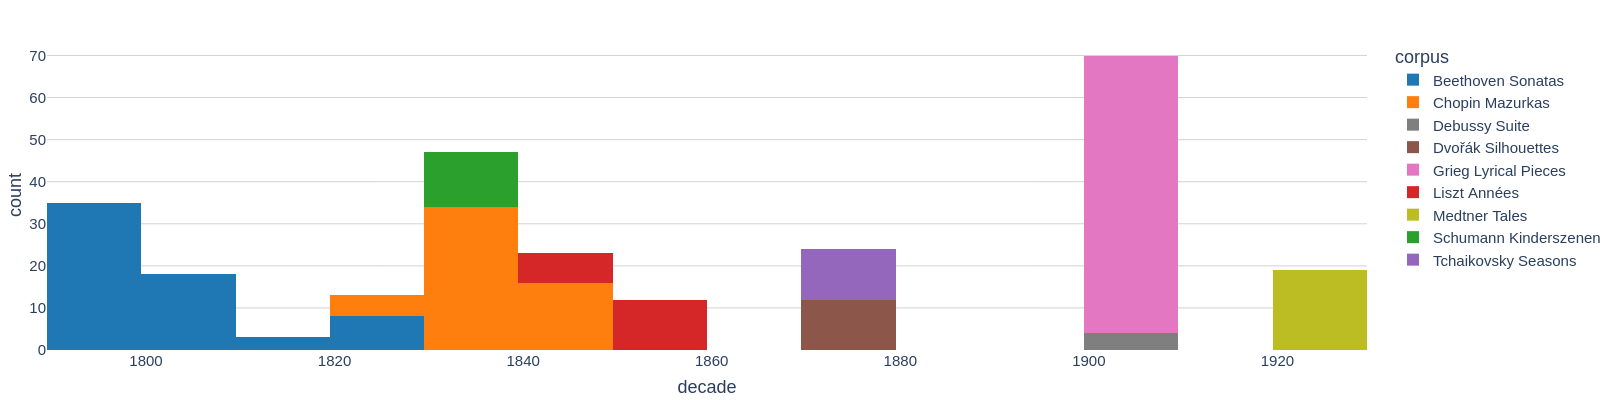

In [27]:
fig = px.histogram(hist_data, x='composed_end', color='corpus',
                   labels=dict(composed_end='decade',
                               count='pieces',
                              ),
                   color_discrete_map=corpus_name_colors,
                   width=1000, height=400,
                  )
fig.update_traces(xbins=dict(
    size=10
))
fig.update_layout(**STD_LAYOUT)
fig.update_yaxes(gridcolor='lightgrey')
fig.write_image(os.path.join(OUTPUT_DIR, "corpus_size_histogram.png"), scale=2)
fig.show()

In [28]:
corpus_metadata = summary.groupby(level=0)
n_pieces = corpus_metadata.size().rename('pieces')
absolute_numbers = dict(
    measures = corpus_metadata.last_mn.sum(),
    length = corpus_metadata.length_qb.sum(),
    notes = corpus_metadata.notes.sum(),
    labels = corpus_metadata.label_count.sum(),
)
absolute = pd.DataFrame.from_dict(absolute_numbers)
relative = absolute.div(n_pieces, axis=0).astype(float).round(1)
complete_summary = pd.concat([pd.concat([n_pieces, absolute], axis=1), relative], axis=1, keys=['absolute', 'per piece'])
complete_summary

absolute                                     \
                            pieces measures     length   notes labels   
corpus                                                                  
beethoven_piano_sonatas         64    11662  35663.375  165948  21965   
chopin_mazurkas                 55     5089   14605.25   57201   9127   
debussy_suite_bergamasque        4      421     1616.0    8210   1013   
dvorak_silhouettes              12      674     1852.5   10649   1539   
grieg_lyrical_pieces            66     5414   16485.25   65774   8231   
liszt_pelerinage                19     2625    9709.25   59534   5069   
medtner_tales                   19     2464     6598.0   42929   6855   
schumann_kinderszenen           13      392      934.0    5223    948   
tchaikovsky_seasons             12     1250     3919.5   18751   3059   

                          per piece                        
                           measures length   notes labels  
corpus                                                     
beethoven_piano_sonatas       182.2  557.2  2592.9  343.2  
chopin_mazurkas                92.5  265.6  1040.0  165.9  
debussy_suite_bergamasque     105.2  404.0  2052.5  253.2  
dvorak_silhouettes             56.2  154.4   887.4  128.2  
grieg_lyrical_pieces           82.0  249.8   996.6  124.7  
liszt_pelerinage              138.2  511.0  3133.4  266.8  
medtner_tales                 129.7  347.3  2259.4  360.8  
schumann_kinderszenen          30.2   71.8   401.8   72.9  
tchaikovsky_seasons           104.2  326.6  1562.6  254.9

In [29]:
ambitus = summary.ambitus.str.extract(r"^(\d+)-(\d+)").astype(int)
ambitus.columns = ['low', 'high']
ambitus['range'] = ambitus.high - ambitus.low
ambitus.head()

low  high  range
corpus                  fname                  
beethoven_piano_sonatas 01-1    32    89     57
                        01-2    31    89     58
                        01-3    31    85     54
                        01-4    31    89     58
                        02-1    31    89     58

In [30]:
ambitus.groupby(level=0).high.max()

corpus
beethoven_piano_sonatas      101
chopin_mazurkas               98
debussy_suite_bergamasque     97
dvorak_silhouettes            97
grieg_lyrical_pieces         102
liszt_pelerinage             102
medtner_tales                100
schumann_kinderszenen         91
tchaikovsky_seasons           93
Name: high, dtype: int64

In [31]:
ambitus.groupby(level=0).low.min()

corpus
beethoven_piano_sonatas      24
chopin_mazurkas              25
debussy_suite_bergamasque    24
dvorak_silhouettes           23
grieg_lyrical_pieces         21
liszt_pelerinage             21
medtner_tales                21
schumann_kinderszenen        25
tchaikovsky_seasons          29
Name: low, dtype: int64

In [32]:
ambitus.groupby(level=0).range.max()

corpus
beethoven_piano_sonatas      72
chopin_mazurkas              68
debussy_suite_bergamasque    70
dvorak_silhouettes           69
grieg_lyrical_pieces         74
liszt_pelerinage             81
medtner_tales                78
schumann_kinderszenen        60
tchaikovsky_seasons          64
Name: range, dtype: int64

# Phrases

In [33]:
phrase_segmented = PhraseSlicer().process_data(selected)
phrases = phrase_segmented.get_slice_info()
print(f"Overall number of phrases is {len(phrases.index)}")
phrases.head(20)

Overall number of phrases is 3597


quarterbeats duration_qb   mc  \
corpus                  fname phrase_slice                                   
beethoven_piano_sonatas 01-1  [0.0, 32.0)               0        32.0    1   
                              [32.0, 64.0)             32        32.0    9   
                              [64.0, 72.0)             64         8.0   17   
                              [72.0, 77.0)             72         5.0   19   
                              [77.0, 163.0)            77        86.0   21   
                              [163.0, 192.0)          163        29.0   42   
                              [192.0, 217.0)          192        25.0   50   
                              [217.0, 249.0)          217        32.0   57   
                              [249.0, 321.0)          249        72.0   65   
                              [321.0, 377.0)          321        56.0   83   
                              [377.0, 401.0)          377        24.0   97   
                              [401.0, 432.0)          401        31.0  103   
                              [432.0, 473.0)          432        41.0  110   
                              [473.0, 559.0)          473        86.0  121   
                              [559.0, 608.0)          559        49.0  142   
                        01-2  [0.0, 11.25)              0       11.25    1   
                              [11.25, 24.0)          45/4       12.75    5   
                              [24.0, 35.25)            24       11.25    9   
                              [35.25, 48.0)         141/4       12.75   13   
                              [48.0, 60.0)             48        12.0   17   

                                               mn mc_onset mn_onset timesig  \
corpus                  fname phrase_slice                                    
beethoven_piano_sonatas 01-1  [0.0, 32.0)       0        0      3/4     2/2   
                              [32.0, 64.0)      8      3/4      3/4     2/2   
                              [64.0, 72.0)     16      3/4      3/4     2/2   
                              [72.0, 77.0)     18      3/4      3/4     2/2   
                              [77.0, 163.0)    20        0        0     2/2   
                              [163.0, 192.0)   41      1/2      1/2     2/2   
                              [192.0, 217.0)   48        0      3/4     2/2   
                              [217.0, 249.0)   55        0        0     2/2   
                              [249.0, 321.0)   63        0        0     2/2   
                              [321.0, 377.0)   81        0        0     2/2   
                              [377.0, 401.0)   95        0        0     2/2   
                              [401.0, 432.0)  101        0        0     2/2   
                              [432.0, 473.0)  108      3/4      3/4     2/2   
                              [473.0, 559.0)  119        0        0     2/2   
                              [559.0, 608.0)  140      1/2      1/2     2/2   
                        01-2  [0.0, 11.25)      0        0      1/2     3/4   
                              [11.25, 24.0)     4     5/16     5/16     3/4   
                              [24.0, 35.25)     8      1/2      1/2     3/4   
                              [35.25, 48.0)    12     5/16     5/16     3/4   
                              [48.0, 60.0)     16      1/2      1/2     3/4   

                                             staff voice volta      label  \
corpus                  fname phrase_slice                                  
beethoven_piano_sonatas 01-1  [0.0, 32.0)        2     1  <NA>       f.i{   
                              [32.0, 64.0)       2     1  <NA>         v{   
                              [64.0, 72.0)       2     1  <NA>        I6{   
                              [72.0, 77.0)       2     1  <NA>        I6{   
                              [77.0, 163.0)      2     1  <NA>   V[V|HC}{   
                              [163.0, 192.0)     2

In [34]:
phrase_segments = phrase_segmented.get_facet('expanded')
phrase_segments

quarterbeats  \
corpus                  fname   phrase_slice   interval                      
beethoven_piano_sonatas 01-1    [0.0, 32.0)    [0.0, 0.0)                0   
                                               [0.0, 9.0)                0   
                                               [9.0, 17.0)               9   
                                               [17.0, 21.0)             17   
                                               [21.0, 25.0)             21   
...                                                                    ...   
tchaikovsky_seasons     op37a12 [493.0, 528.0) [495.0, 499.0)          495   
                                               [499.0, 501.0)          499   
                                               [501.0, 504.0)          501   
                                               [504.0, 504.0)          504   
                                               [504.0, 528.0)          504   

                                                               duration_qb  \
corpus                  fname   phrase_slice   interval                      
beethoven_piano_sonatas 01-1    [0.0, 32.0)    [0.0, 0.0)              0.0   
                                               [0.0, 9.0)              9.0   
                                               [9.0, 17.0)             8.0   
                                               [17.0, 21.0)            4.0   
                                               [21.0, 25.0)            4.0   
...                                                                    ...   
tchaikovsky_seasons     op37a12 [493.0, 528.0) [495.0, 499.0)          4.0   
                                               [499.0, 501.0)          2.0   
                                               [501.0, 504.0)          3.0   
                                               [504.0, 504.0)          0.0   
                                               [504.0, 528.0)         24.0   

                                                                mc   mn  \
corpus                  fname   phrase_slice   interval                   
beethoven_piano_sonatas 01-1    [0.0, 32.0)    [0.0, 0.0)        1    0   
                                               [0.0, 9.0)        1    0   
                                               [9.0, 17.0)       4    3   
                                               [17.0, 21.0)      6    5   
                                               [21.0, 25.0)      7    6   
...                                                            ...  ...   
tchaikovsky_seasons     op37a12 [493.0, 528.0) [495.0, 499.0)  166  166   
                                               [499.0, 501.0)  167  167   
                                               [501.0, 504.0)  168  168   
                                               [504.0, 504.0)  169  169   
                                               [504.0, 528.0)  169  169   

                                                              mc_onset  \
corpus                  fname   phrase_slice   interval                  
beethoven_piano_sonatas 01-1    [0.0, 32.0)    [0.0, 0.0)            0   
                                               [0.0, 9.0)            0   
                                               [9.0, 17.0)           0   
                                               [17.0, 21.0)          0   
                                               [21.0, 25.0)          0   
...                                                                ...   
tchaikovsky_seasons     op37a12 [493.0, 528.0) [495.0, 499.0)        0   
                                               [499.0, 501.0)      1/4   
                                               [501.0, 504.0)        0   
                                               [504.0, 504.0)        0   
                                               [504.0, 528.0)        0   

                                                              mn_onset  \
corpus             

In [35]:
phrases[phrases.duration_qb > 50]

quarterbeats duration_qb   mc  \
corpus                  fname   phrase_slice                                   
beethoven_piano_sonatas 01-1    [77.0, 163.0)            77        86.0   21   
                                [249.0, 321.0)          249        72.0   65   
                                [321.0, 377.0)          321        56.0   83   
                                [473.0, 559.0)          473        86.0  121   
                        02-1    [182.5, 242.0)        365/2        59.5   93   
...                                                     ...         ...  ...   
medtner_tales           op48n02 [268.0, 319.0)          268        51.0   91   
                                [493.0, 559.0)          493        66.0  166   
tchaikovsky_seasons     op37a02 [284.0, 338.0)          284        54.0  143   
                        op37a05 [222.0, 274.5)          222        52.5   77   
                        op37a07 [171.0, 224.0)          171        53.0   43   

                                                 mn mc_onset mn_onset timesig  \
corpus                  fname   phrase_slice                                    
beethoven_piano_sonatas 01-1    [77.0, 163.0)    20        0        0     2/2   
                                [249.0, 321.0)   63        0        0     2/2   
                                [321.0, 377.0)   81        0        0     2/2   
                                [473.0, 559.0)  119        0        0     2/2   
                        02-1    [182.5, 242.0)   92        0        0     2/4   
...                                             ...      ...      ...     ...   
medtner_tales           op48n02 [268.0, 319.0)   90        0        0     3/4   
                                [493.0, 559.0)  165        0        0     3/4   
tchaikovsky_seasons     op37a02 [284.0, 338.0)  143        0        0     2/4   
                        op37a05 [222.0, 274.5)   77        0        0     9/8   
                        op37a07 [171.0, 224.0)   43      3/4      3/4     4/4   

                                               staff voice volta      label  \
corpus                  fname   phrase_slice                                  
beethoven_piano_sonatas 01-1    [77.0, 163.0)      2     1  <NA>   V[V|HC}{   
                                [249.0, 321.0)     2     1  <NA>   V[V|HC}{   
                                [321.0, 377.0)     2     1  <NA>   V[V|HC}{   
                                [473.0, 559.0)     2     1  <NA>    V[V|HC{   
                        02-1    [182.5, 242.0)     2     1  <NA>    I|PAC}{   
...                                              ...   ...   ...        ...   
medtner_tales           op48n02 [268.0, 319.0)     2     1  <NA>         i{   
                                [493.0, 559.0)     2     1  <NA>      i[i}{   
tchaikovsky_seasons     op37a02 [284.0, 338.0)     2     1  <NA>  bVII.V65{   
                        op37a05 [222.0, 274.5)     2     1  <NA>    bIII64{   
                        op37a07 [171.0, 224.0)     2     1  <NA>     V7(9){   

                                               alt_label globalkey localkey  \
corpus                  fname   phrase_slice                                  
beethoven_piano_sonatas 01-1    [77.0, 163.0)        NaN         f      III   
                                [249.0, 321.0)       NaN         f        v   
                                [321.0, 377.0)       NaN         f        i   
                                [473.0, 559.0)       NaN         f        i   
                        02-1    [182.5, 242.0)       NaN         A        V   
...                                                  ...       ...      ...   
medtner_tales           op48n02 [268.0, 319.0)       NaN         g        v   
                                [493.0, 559.0)       NaN         g        i   
tchaikovsky_seasons     op37a02 [284.0, 338.0)       NaN         D     bVII   
                        op37a05 [222.0, 274.5)       Na

Filtered out the 53 phrases incorporating more than one time signature.


#time signatures  #phrases
0                 1      3544
1                 2        52
2                 3         1

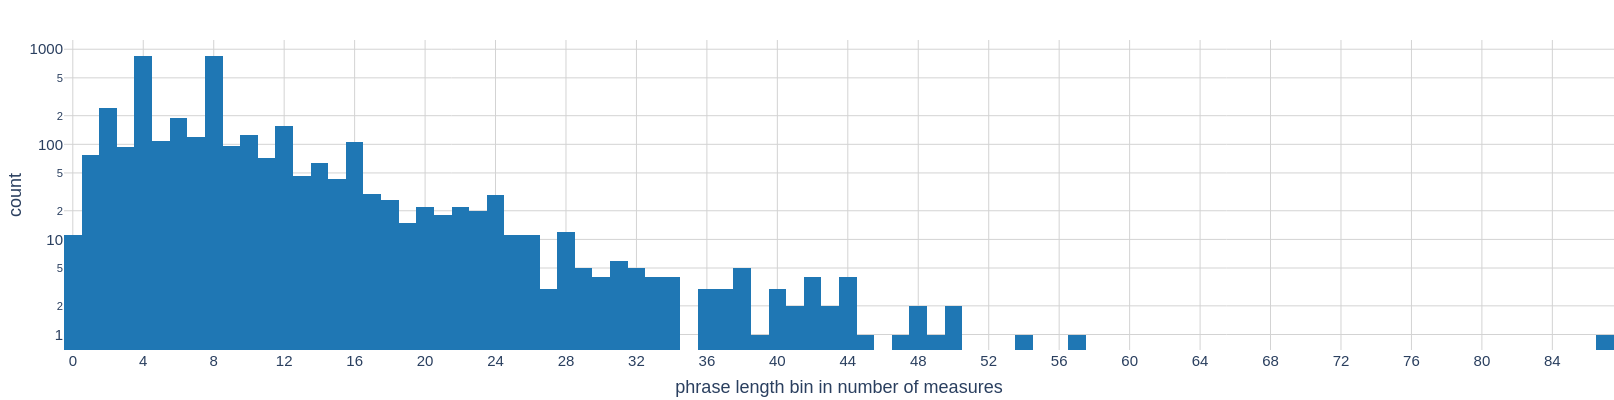

In [36]:
phrase2timesigs = phrase_segments.groupby(level=[0,1,2]).timesig.unique()
n_timesignatures_per_phrase = phrase2timesigs.map(len)
uniform_timesigs = phrase2timesigs[n_timesignatures_per_phrase == 1].map(lambda l: l[0])
more_than_one = n_timesignatures_per_phrase > 1
print(f"Filtered out the {more_than_one.sum()} phrases incorporating more than one time signature.")
n_timesigs = n_timesignatures_per_phrase.value_counts()
display(n_timesigs.reset_index().rename(columns=dict(index='#time signatures', timesig='#phrases')))
uniform_timesig_phrases = phrases.loc[uniform_timesigs.index]
timesig_in_quarterbeats = uniform_timesigs.map(Fraction) * 4
exact_measure_lengths = uniform_timesig_phrases.duration_qb / timesig_in_quarterbeats
uniform_timesigs = pd.concat([exact_measure_lengths.rename('duration_measures'), uniform_timesig_phrases], axis=1)
fig = px.histogram(uniform_timesigs, x='duration_measures', log_y=True,
                   labels=dict(duration_measures='phrase length bin in number of measures'),
                   color_discrete_sequence=corpus_color_scale,
                   height=400,
                   width = 1000,
                  )
fig.update_traces(xbins=dict( # bins used for histogram
        #start=0.0,
        #end=100.0,
        size=1
    ))
fig.update_layout(**STD_LAYOUT)
fig.update_xaxes(dtick=4, gridcolor='lightgrey')
fig.update_yaxes(gridcolor='lightgrey')
fig.write_image(os.path.join(OUTPUT_DIR, "phrase_lengths.png"), scale=2)
fig.show()

In [37]:
uniform_timesigs[uniform_timesigs.duration_measures > 80]

duration_measures  \
corpus                    fname                phrase_slice                      
debussy_suite_bergamasque l075-02_suite_menuet [51.0, 312.0)              87.0   

                                                             quarterbeats  \
corpus                    fname                phrase_slice                 
debussy_suite_bergamasque l075-02_suite_menuet [51.0, 312.0)           51   

                                                             duration_qb  mc  \
corpus                    fname                phrase_slice                    
debussy_suite_bergamasque l075-02_suite_menuet [51.0, 312.0)       261.0  18   

                                                              mn mc_onset  \
corpus                    fname                phrase_slice                 
debussy_suite_bergamasque l075-02_suite_menuet [51.0, 312.0)  18        0   

                                                             mn_onset timesig  \
corpus                    fname                phrase_slice                     
debussy_suite_bergamasque l075-02_suite_menuet [51.0, 312.0)        0     3/4   

                                                             staff voice  \
corpus                    fname                phrase_slice                
debussy_suite_bergamasque l075-02_suite_menuet [51.0, 312.0)     2     1   

                                                             volta    label  \
corpus                    fname                phrase_slice                   
debussy_suite_bergamasque l075-02_suite_menuet [51.0, 312.0)  <NA>  i|PAC}{   

                                                             alt_label  \
corpus                    fname                phrase_slice              
debussy_suite_bergamasque l075-02_suite_menuet [51.0, 312.0)       NaN   

                                                             globalkey  \
corpus                    fname                phrase_slice              
debussy_suite_bergamasque l075-02_suite_menuet [51.0, 312.0)         a   

                                                             localkey pedal  \
corpus                    fname                phrase_slice                   
debussy_suite_bergamasque l075-02_suite_menuet [51.0, 312.0)        i   NaN   

                                                             chord special  \
corpus                    fname                phrase_slice                  
debussy_suite_bergamasque l075-02_suite_menuet [51.0, 312.0)     i     NaN   

                                                             numeral form  \
corpus                    fname                phrase_slice                 
debussy_suite_bergamasque l075-02_suite_menuet [51.0, 312.0)       i  NaN   

                                                             figbass changes  \
corpus                    fname                phrase_slice                    
debussy_suite_bergamasque l075-02_suite_menuet [51.0, 312.0)     NaN     NaN   

                                                             relativeroot  \
corpus                    fname                phrase_slice                 
debussy_suite_bergamasque l075-02_suite_menuet [51.0, 312.0)          NaN   

                                                             cadence  \
corpus                    fname                phrase_slice            
debussy_suite_bergamasque l075-02_suite_menuet [51.0, 312.0)     PAC   

                                                             phraseend  \
corpus                    fname                phrase_slice              
debussy_suite_bergamasque l075-02_suite_menuet [51.0, 312.0)        }{   

                                                             chord_type  \
corpus                    fname                phrase_slice               
debussy_suite_bergamasque l075-02_suite_menuet [51.0, 312.0)          m   

                                                             globalkey_is_minor  \
corpus                   

# Keys

In [38]:
from ms3 import roman_numeral2fifths, transform, resolve_all_relative_numerals, replace_boolean_mode_by_strings
keys_segmented = LocalKeySlicer().process_data(selected)
keys = keys_segmented.get_slice_info()
print(f"Overall number of key segments is {len(keys.index)}")
keys["localkey_fifths"] = transform(keys, roman_numeral2fifths, ['localkey', 'globalkey_is_minor'])
keys.head(20)

Overall number of key segments is 1476


quarterbeats duration_qb  mc  mn  \
corpus                  fname localkey_slice                                    
beethoven_piano_sonatas 01-1  [0.0, 41.0)               0        41.0   1   0   
                              [41.0, 209.0)            41       168.0  12  11   
                              [209.0, 247.0)          209        38.0  55  53   
                              [247.0, 276.0)          247        29.0  64  62   
                              [276.0, 284.0)          276         8.0  71  69   
                              [284.0, 307.0)          284        23.0  73  71   
                              [307.0, 608.0)          307       301.0  79  77   
                        01-2  [0.0, 48.0)               0        48.0   1   0   
                              [48.0, 61.0)             48        13.0  17  16   
                              [61.0, 91.5)             61        30.5  22  21   
                              [91.5, 183.0)         183/2        91.5  32  31   
                        01-3  [0.0, 12.0)               0        12.0   1   0   
                              [12.0, 49.0)             12        37.0   5   4   
                              [49.0, 76.0)             49        27.0  19  17   
                              [76.0, 120.0)            76        44.0  28  26   
                              [120.0, 138.0)          120        18.0  43  40   
                              [138.0, 157.0)          138        19.0  49  46   
                              [157.0, 219.0)          157        62.0  57  53   
                        01-4  [0.0, 47.0)               0        47.0   1   0   
                              [47.0, 224.0)            47       177.0  13  12   

                                             mc_onset mn_onset timesig staff  \
corpus                  fname localkey_slice                                   
beethoven_piano_sonatas 01-1  [0.0, 41.0)           0      3/4     2/2     2   
                              [41.0, 209.0)         0        0     2/2     2   
                              [209.0, 247.0)        0        0     2/2     2   
                              [247.0, 276.0)      1/2      1/2     2/2     2   
                              [276.0, 284.0)      3/4      3/4     2/2     2   
                              [284.0, 307.0)      3/4      3/4     2/2     2   
                              [307.0, 608.0)      1/2      1/2     2/2     2   
                        01-2  [0.0, 48.0)           0      1/2     3/4     2   
                              [48.0, 61.0)        1/2      1/2     3/4     2   
                              [61.0, 91.5)          0        0     3/4     2   
                              [91.5, 183.0)       1/8      1/8     3/4     2   
                        01-3  [0.0, 12.0)           0      1/2     3/4     2   
                              [12.0, 49.0)        1/2      1/2     3/4     2   
                              [49.0, 76.0)          0        0     3/4     2   
                              [76.0, 120.0)         0        0     3/4     2   
                              [120.0, 138.0)        0      1/2     3/4     2   
                              [138.0, 157.0)      1/2      1/2     3/4     2   
                              [157.0, 219.0)        0        0     3/4     2   
                        01-4  [0.0, 47.0)           0        0     2/2     2   
                              [47.0, 224.0)       3/4      3/4     2/2     2   

                                             voice volta        label  \
corpus                  fname localkey_slice                            
beethoven_piano_sonatas 01-1  [0.0, 41.0)        1  <NA>         f.i{   
                              [41.0, 209.0)      1  <NA>     III.IVM2   
                              [209.0, 247.0)     1  <NA>  iv.viio65/V   
                              [247.0, 276.0)     1  <NA>        v.It6   
                              [276.0, 284.0)     1  <NA>     iv

In [39]:
keys.duration_qb.sum()

91369.25

In [40]:
phrases.duration_qb.sum()

91328.25

In [41]:
key_durations = keys.groupby(['globalkey_is_minor', 'localkey']).duration_qb.sum().sort_values(ascending=False)
print(f"{len(key_durations)} keys overall including hierarchical such as 'III/v'.")

86 keys overall including hierarchical such as 'III/v'.


In [42]:
keys_resolved = resolve_all_relative_numerals(keys)
key_resolved_durations = keys_resolved.groupby(['globalkey_is_minor', 'localkey']).duration_qb.sum().sort_values(ascending=False)
print(f"{len(key_resolved_durations)} keys overall after resolving hierarchical ones.")
key_resolved_durations

62 keys overall after resolving hierarchical ones.


globalkey_is_minor  localkey
False               I           36743.208333
True                i              24813.625
False               V                 3491.5
True                I            3421.666667
                    III               3333.0
                                    ...     
False               bI                  22.0
                    bvii                12.0
                    #I                  11.0
                    bv                   8.0
                    bii                  4.0
Name: duration_qb, Length: 62, dtype: object

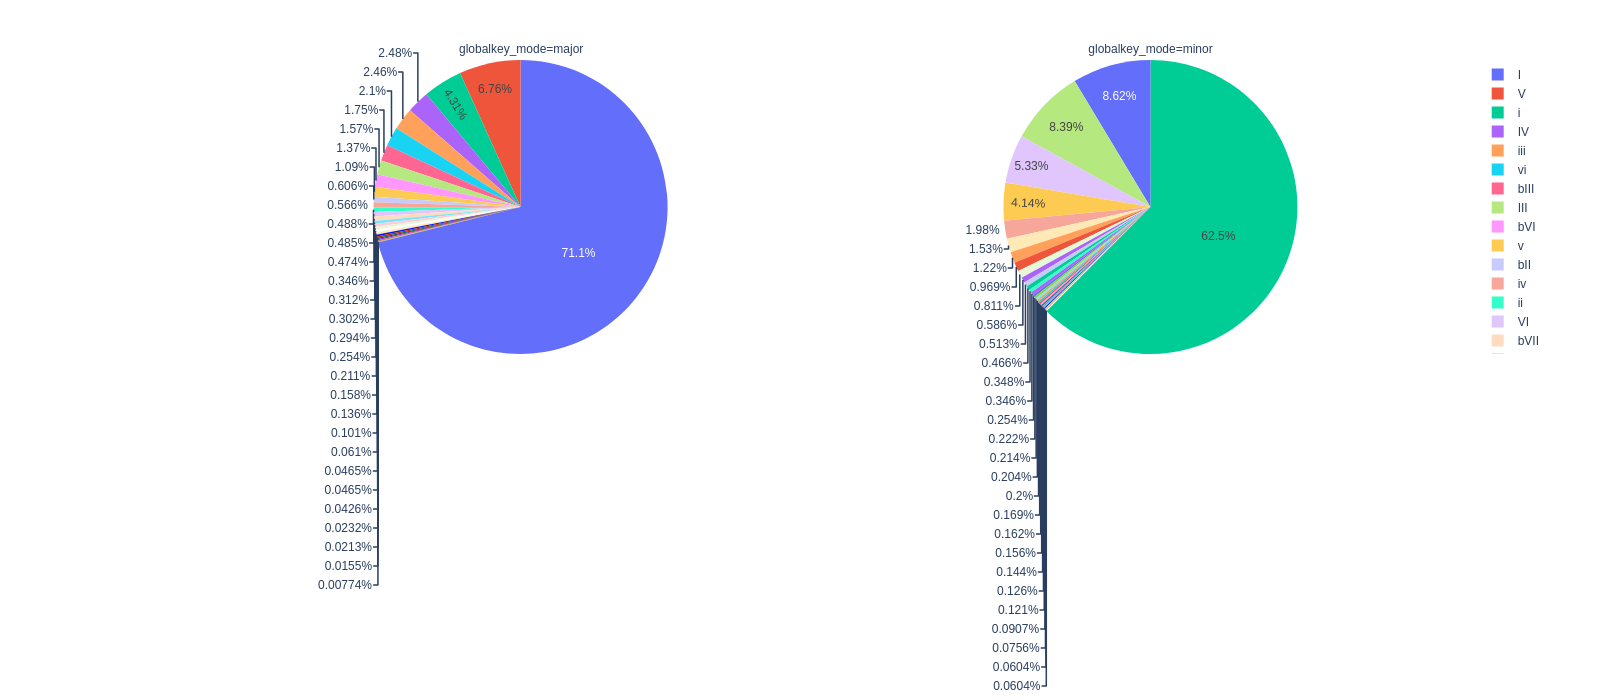

In [43]:
pie_data = replace_boolean_mode_by_strings(key_resolved_durations.reset_index())
px.pie(pie_data, names='localkey', values='duration_qb', facet_col='globalkey_mode', height=700)

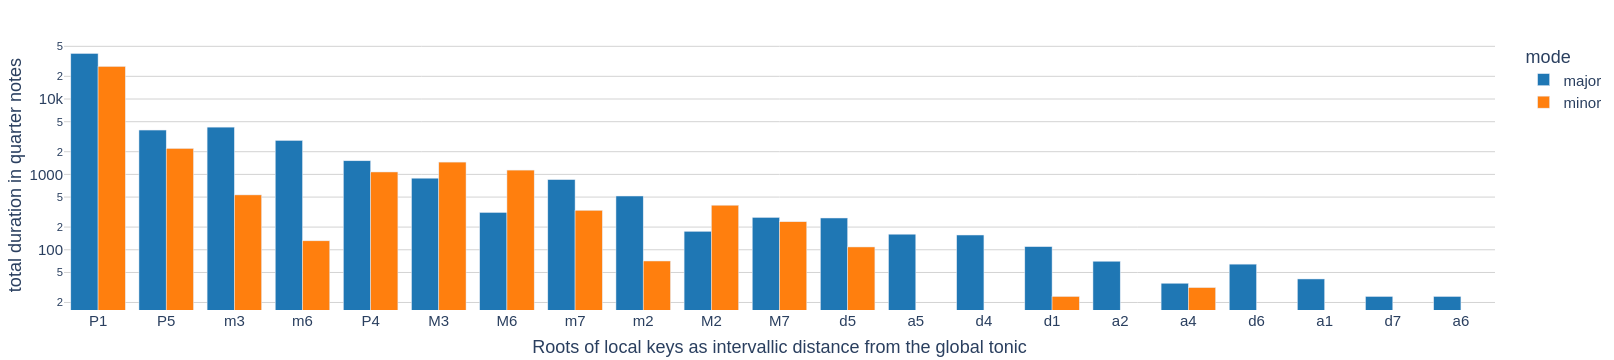

In [44]:
localkey_fifths_durations = keys.groupby(['localkey_fifths', 'localkey_is_minor']).duration_qb.sum()
# sort by stacked bar length:
localkey_fifths_durations = localkey_fifths_durations.sort_values(key=lambda S: S.index.get_level_values(0).map(S.groupby(level=0).sum()), ascending=False)
bar_data = replace_boolean_mode_by_strings(localkey_fifths_durations.reset_index())
bar_data.localkey_fifths = bar_data.localkey_fifths.map(fifths2iv)
fig = px.bar(bar_data, x='localkey_fifths', y='duration_qb', color='localkey_mode', log_y=True, barmode='group',
             labels=dict(localkey_fifths='Roots of local keys as intervallic distance from the global tonic', 
                   duration_qb='total duration in quarter notes',
                   localkey_mode='mode'
                  ),
             color_discrete_sequence=corpus_color_scale,
             width=1000)
fig.update_layout(**STD_LAYOUT)
fig.update_yaxes(gridcolor='lightgrey')
fig.write_image(os.path.join(OUTPUT_DIR, "key_segments.png"), scale=2)
fig.show()

In [45]:
localkey_fifths_durations_stacked = localkey_fifths_durations.groupby(level=0).sum().sort_values()
pd.concat([localkey_fifths_durations_stacked, localkey_fifths_durations_stacked.rename('fraction') / localkey_fifths_durations_stacked.sum()], axis=1)

duration_qb  fraction
localkey_fifths                       
 10                     24.0  0.000263
-9                      24.0  0.000263
 7                      41.0  0.000449
-11                     64.5  0.000706
 6                      67.5  0.000739
 9                      70.5  0.000772
-7                     134.0  0.001467
-8                     157.0  0.001718
 8                     161.0  0.001762
-6                     373.0  0.004082
 5                     504.0  0.005516
 2                566.083333  0.006196
-5                    587.75  0.006433
-2                    1186.5  0.012986
 3               1453.208333  0.015905
 4               2347.458333  0.025692
-1                    2593.0  0.028379
-4                  2951.625  0.032304
-3                   4772.25   0.05223
 1                  6084.625  0.066594
 0                  67206.25  0.735546

In [46]:
keys[keys.localkey_fifths == -9]

quarterbeats duration_qb  \
corpus           fname             localkey_slice                            
liszt_pelerinage 161.01_Sposalizio [362.0, 386.0)          362        24.0   

                                                   mc  mn mc_onset mn_onset  \
corpus           fname             localkey_slice                             
liszt_pelerinage 161.01_Sposalizio [362.0, 386.0)  62  62        0        0   

                                                  timesig staff voice volta  \
corpus           fname             localkey_slice                             
liszt_pelerinage 161.01_Sposalizio [362.0, 386.0)     6/4     2     1  <NA>   

                                                           label alt_label  \
corpus           fname             localkey_slice                            
liszt_pelerinage 161.01_Sposalizio [362.0, 386.0)  bbVII.V(+964)       NaN   

                                                  globalkey localkey pedal  \
corpus           fname             localkey_slice                            
liszt_pelerinage 161.01_Sposalizio [362.0, 386.0)         E    bbVII   NaN   

                                                     chord special numeral  \
corpus           fname             localkey_slice                            
liszt_pelerinage 161.01_Sposalizio [362.0, 386.0)  V(+964)     NaN       V   

                                                  form figbass changes  \
corpus           fname             localkey_slice                        
liszt_pelerinage 161.01_Sposalizio [362.0, 386.0)  NaN     NaN    +964   

                                                  relativeroot cadence  \
corpus           fname             localkey_slice                        
liszt_pelerinage 161.01_Sposalizio [362.0, 386.0)          NaN     NaN   

                                                  phraseend chord_type  \
corpus           fname             localkey_slice                        
liszt_pelerinage 161.01_Sposalizio [362.0, 386.0)       NaN          M   

                                                  globalkey_is_minor  \
corpus           fname             localkey_slice                      
liszt_pelerinage 161.01_Sposalizio [362.0, 386.0)              False   

                                                  localkey_is_minor  \
corpus           fname             localkey_slice                     
liszt_pelerinage 161.01_Sposalizio [362.0, 386.0)             False   

                                                  chord_tones added_tones  \
corpus           fname             localkey_slice                           
liszt_pelerinage 161.01_Sposalizio [362.0, 386.0)   (1, 0, 4)        (3,)   

                                                  root bass_note pedalend  \
corpus           fname             localkey_slice                           
liszt_pelerinage 161.01_Sposalizio [362.0, 386.0)    1         1      NaN   

                                                   localkey_fifths  
corpus           fname             localkey_slice                   
liszt_pelerinage 161.01_Sposalizio [362.0, 386.0)               -9

In [47]:
keys[keys.localkey_fifths == 10]

quarterbeats  \
corpus           fname                          localkey_slice                
liszt_pelerinage 161.04_Sonetto_47_del_Petrarca [140.0, 164.0)          140   

                                                               duration_qb  \
corpus           fname                          localkey_slice               
liszt_pelerinage 161.04_Sonetto_47_del_Petrarca [140.0, 164.0)        24.0   

                                                                mc  mn  \
corpus           fname                          localkey_slice           
liszt_pelerinage 161.04_Sonetto_47_del_Petrarca [140.0, 164.0)  28  28   

                                                               mc_onset  \
corpus           fname                          localkey_slice            
liszt_pelerinage 161.04_Sonetto_47_del_Petrarca [140.0, 164.0)        0   

                                                               mn_onset  \
corpus           fname                          localkey_slice            
liszt_pelerinage 161.04_Sonetto_47_del_Petrarca [140.0, 164.0)        0   

                                                               timesig staff  \
corpus           fname                          localkey_slice                 
liszt_pelerinage 161.04_Sonetto_47_del_Petrarca [140.0, 164.0)     6/4     2   

                                                               voice volta  \
corpus           fname                          localkey_slice               
liszt_pelerinage 161.04_Sonetto_47_del_Petrarca [140.0, 164.0)     1  <NA>   

                                                                      label  \
corpus           fname                          localkey_slice                
liszt_pelerinage 161.04_Sonetto_47_del_Petrarca [140.0, 164.0)  #VI.viio43{   

                                                               alt_label  \
corpus           fname                          localkey_slice             
liszt_pelerinage 161.04_Sonetto_47_del_Petrarca [140.0, 164.0)       NaN   

                                                               globalkey  \
corpus           fname                          localkey_slice             
liszt_pelerinage 161.04_Sonetto_47_del_Petrarca [140.0, 164.0)        Db   

                                                               localkey pedal  \
corpus           fname                          localkey_slice                  
liszt_pelerinage 161.04_Sonetto_47_del_Petrarca [140.0, 164.0)      #VI   NaN   

                                                                 chord  \
corpus           fname                          localkey_slice           
liszt_pelerinage 161.04_Sonetto_47_del_Petrarca [140.0, 164.0)  viio43   

                                                               special  \
corpus           fname                          localkey_slice           
liszt_pelerinage 161.04_Sonetto_47_del_Petrarca [140.0, 164.0)     NaN   

                                                               numeral form  \
corpus           fname                          localkey_slice                
liszt_pelerinage 161.04_Sonetto_47_del_Petrarca [140.0, 164.0)     vii    o   

                                                               figbass  \
corpus           fname                          localkey_slice           
liszt_pelerinage 161.04_Sonetto_47_del_Petrarca [140.0, 164.0)      43   

                                                               changes  \
corpus           fname                          localkey_slice           
liszt_pelerinage 161.04_Sonetto_47_del_Petrarca [140.0, 164.0)     NaN   

                                                               relativeroot  \
corpus           fname                          localkey_slice                
liszt_pelerinage 161.04_Sonetto_47_del_Petrarca [140.0, 164.0)          NaN   

                                                               cadence  \
corpus           fname                          localkey_

# Cadences

In [48]:
all_annotations.cadence.value_counts()

PAC    1286
HC      895
IAC     630
PC       60
EC       47
DC       30
Name: cadence, dtype: int64

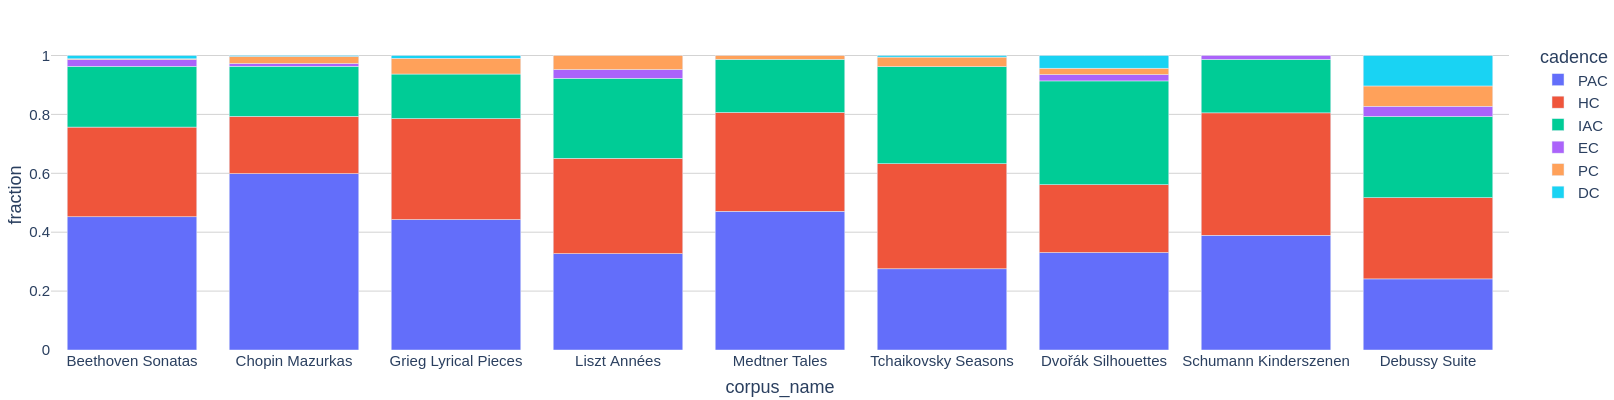

In [49]:
cadence_count_per_corpus = all_annotations.groupby("corpus_name").cadence.value_counts().sort_values(ascending=False)
cadence_fraction_per_corpus = cadence_count_per_corpus / cadence_count_per_corpus.groupby(level=0).sum()
fig = px.bar(cadence_fraction_per_corpus.rename('count').reset_index(), x='corpus_name', y='count', color='cadence',
             labels=dict(count='fraction', corpus=''), 
             height=400, width=900,
       category_orders=dict(corpus=chronological_corpus_names))
      #color_discrete_map=cadence_colors, 

fig.update_layout(**STD_LAYOUT)
fig.update_yaxes(gridcolor='lightgrey')
fig.write_image(os.path.join(OUTPUT_DIR, "cadences.png"), scale=2)
fig.show()

# Harmony labels
## Unigrams
For computing unigram statistics, the tokens need to be grouped by their occurrence within a major or a minor key because this changes their meaning. To that aim, the annotated corpus needs to be sliced into contiguous localkey segments which are then grouped into a major (`is_minor=False`) and a minor group.

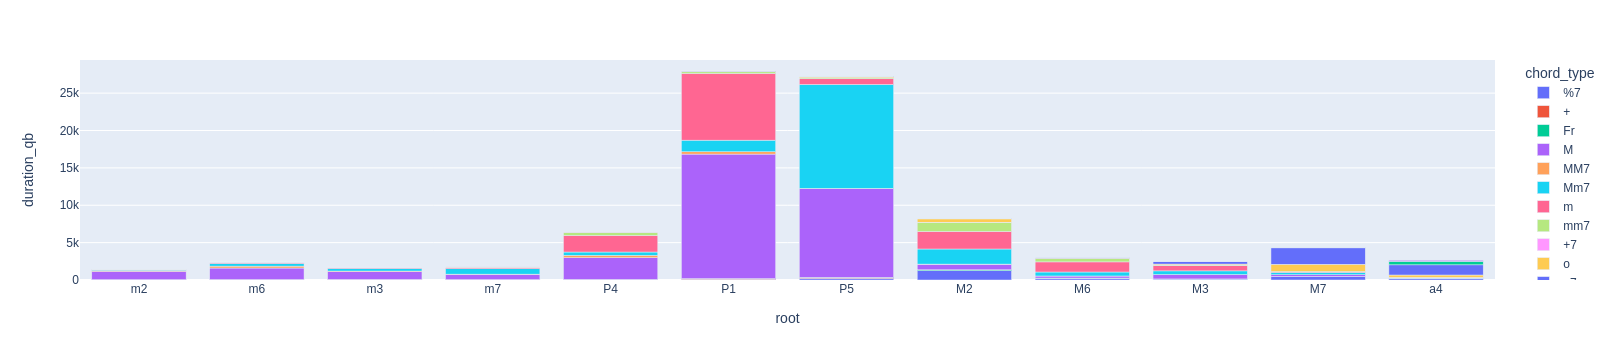

In [50]:
root_durations = all_chords[all_chords.root.between(-5,6)].groupby(['root', 'chord_type']).duration_qb.sum()
# sort by stacked bar length:
#root_durations = root_durations.sort_values(key=lambda S: S.index.get_level_values(0).map(S.groupby(level=0).sum()), ascending=False)
bar_data = root_durations.reset_index()
bar_data.root = bar_data.root.map(fifths2iv)
px.bar(bar_data, x='root', y='duration_qb', color='chord_type')

In [51]:
relative_roots = all_chords[['numeral', 'duration_qb', 'relativeroot', 'localkey_is_minor', 'chord_type']].copy()
relative_roots['relativeroot_resolved'] = transform(relative_roots, resolve_relative_keys, ['relativeroot', 'localkey_is_minor'])
has_rel = relative_roots.relativeroot_resolved.notna()
relative_roots.loc[has_rel, 'localkey_is_minor'] = relative_roots.loc[has_rel, 'relativeroot_resolved'].str.islower()
relative_roots['root'] = transform(relative_roots, roman_numeral2fifths, ['numeral', 'localkey_is_minor'])
chord_type_frequency = all_chords.chord_type.value_counts()
replace_rare = map_dict({t: 'other' for t in chord_type_frequency[chord_type_frequency < 500].index})
relative_roots['type_reduced'] = relative_roots.chord_type.map(replace_rare)
#is_special = relative_roots.chord_type.isin(('It', 'Ger', 'Fr'))
#relative_roots.loc[is_special, 'root'] = -4

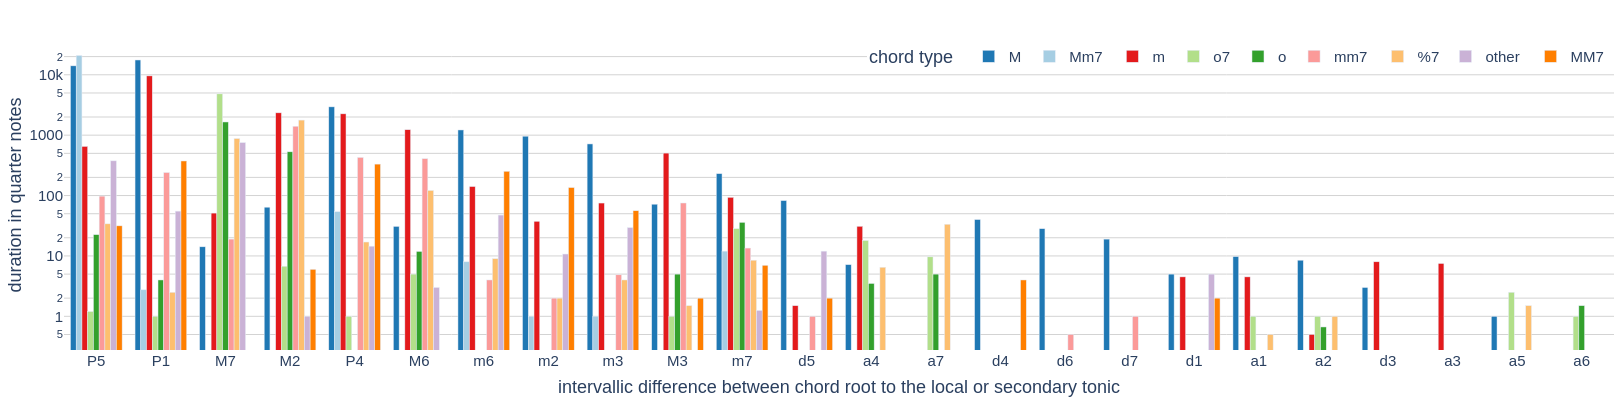

In [52]:
root_durations = relative_roots.groupby(['root', 'type_reduced']).duration_qb.sum().sort_values(ascending=False)
bar_data = root_durations.reset_index()
bar_data.root = bar_data.root.map(fifths2iv)
root_order = bar_data.groupby('root').duration_qb.sum().sort_values(ascending=False).index.to_list()
type_colors = dict(zip(('Mm7', 'M', 'o7', 'o', 'mm7', 'm', '%7', 'MM7', 'other'), colorlover.scales['9']['qual']['Paired']))
fig = px.bar(bar_data, x='root', y='duration_qb', color='type_reduced', barmode='group', log_y=True,
             color_discrete_map=type_colors, 
             category_orders=dict(root=root_order,
                                  type_reduced=relative_roots.type_reduced.value_counts().index.to_list(),
                                 ),
            labels=dict(root="intervallic difference between chord root to the local or secondary tonic",
                        duration_qb="duration in quarter notes",
                        type_reduced="chord type"
                       ),
             width=1000,
             height=400,
            )
fig.update_layout(**STD_LAYOUT,
                  legend=dict(
                      orientation='h',
                      xanchor="right",
                      x=1,
                      y=1,
                  )
                 )
fig.update_yaxes(gridcolor='lightgrey')
fig.write_image(os.path.join(OUTPUT_DIR, "chord_roots.png"), scale=2)
fig.show()

In [53]:
mode_slices = ModeGrouper().process_data(keys_segmented)

### Whole dataset

In [54]:
unigrams = ChordSymbolUnigrams(once_per_group=True).process_data(mode_slices)

In [55]:
unigrams.get()

localkey_is_minor  chord      
False              I              5206
                   V7             2579
                   V              2164
                   I6             1753
                   IV              970
                                  ... 
True               vii%7/IV          1
                   vii%7/V/III       1
                   vii(11)           1
                   VI(11)            1
                   ii6/iv            1
Name: count, Length: 3732, dtype: int64

In [56]:
modes = {True: 'MINOR', False: 'MAJOR'}
for (is_minor,), ugs in unigrams.iter():
    print(f"{modes[is_minor]} UNIGRAMS\n{ugs.shape[0]} types, {ugs.sum()} tokens")
    print(ugs.head(20).to_string())

MAJOR UNIGRAMS
2008 types, 35438 tokens
chord
I        5206
V7       2579
V        2164
I6       1753
IV        970
V(64)     707
V43       669
V2        645
V6        636
vi        602
ii        559
ii6       545
V65       534
IV6       467
I64       448
V7(9)     366
viio6     346
V7/V      329
ii7       278
V7/IV     230
MINOR UNIGRAMS
1724 types, 21442 tokens
chord
i          2708
V          1413
V7         1188
i6          911
iv          487
V(64)       461
V6          356
VI          325
V43         304
iv6         304
i64         240
I           235
V65         229
III         221
V2          215
#viio43     209
bII         164
v           162
V7/III      158
#viio7      156


### Per corpus

In [57]:
corpus_wise_unigrams = Pipeline([CorpusGrouper(), ChordSymbolUnigrams(once_per_group=True)]).process_data(mode_slices)

In [58]:
corpus_wise_unigrams.get()

localkey_is_minor  corpus                   chord   
False              beethoven_piano_sonatas  I           2208
                                            V           1178
                                            I6          1122
                                            V7          1027
                                            V6           466
                                                        ... 
True               tchaikovsky_seasons      i(4)/v         1
                                            i/v            1
                                            ii64           1
                                            v6/iv          1
                                            ii%65(2)       1
Name: count, Length: 6717, dtype: int64

In [59]:
for (is_minor, corpus_name), ugs in corpus_wise_unigrams.iter():
    print(f"{corpus_name} {modes[is_minor]} unigrams ({ugs.shape[0]} types, {ugs.sum()} tokens)")
    print(ugs.head(5).to_string())

beethoven_piano_sonatas MAJOR unigrams (839 types, 15130 tokens)
chord
I     2208
V     1178
I6    1122
V7    1027
V6     466
chopin_mazurkas MAJOR unigrams (460 types, 5257 tokens)
chord
I       954
V7      656
V       251
IV      183
V7/V    133
debussy_suite_bergamasque MAJOR unigrams (94 types, 335 tokens)
chord
I         24
V7        21
iii       19
IV6       12
V7(+2)    12
dvorak_silhouettes MAJOR unigrams (140 types, 1067 tokens)
chord
I     254
I6    103
V7     89
V      79
IV     46
grieg_lyrical_pieces MAJOR unigrams (659 types, 4882 tokens)
chord
I     566
V7    264
V     224
IV    127
vi    116
liszt_pelerinage MAJOR unigrams (552 types, 3455 tokens)
chord
I     501
V7    250
V     155
I6    109
IV    108
medtner_tales MAJOR unigrams (636 types, 2864 tokens)
chord
I     263
V     139
V7    122
I6     83
IV     61
schumann_kinderszenen MAJOR unigrams (114 types, 714 tokens)
chord
I      106
I6      69
V       65
V7      50
V43     30
tchaikovsky_seasons MAJOR unigrams (194 

In [60]:
types_shared_between_corpora = {}
for (is_minor, corpus_name), ugs in corpus_wise_unigrams.iter():
    if is_minor in types_shared_between_corpora:
        types_shared_between_corpora[is_minor] = types_shared_between_corpora[is_minor].intersection(ugs.index) 
    else:
        types_shared_between_corpora[is_minor] = set(ugs.index)
types_shared_between_corpora = {k: sorted(v, key=lambda x: unigrams.get()[(k, x)], reverse=True) for k, v in types_shared_between_corpora.items()}
n_types = {k: len(v) for k, v in types_shared_between_corpora.items()}
print(f"Chords which occur in all corpora, sorted by descending global frequency:\n{types_shared_between_corpora}\nCounts: {n_types}")

Chords which occur in all corpora, sorted by descending global frequency:
{False: ['I', 'V7', 'V', 'I6', 'IV', 'V43', 'V2', 'V6', 'vi', 'ii', 'ii6', 'V65', 'IV6', 'I64', 'viio6', 'ii7', 'V7/IV', 'V64', 'ii65', 'vi6', 'iii', 'V7(4)', 'V/V', 'ii2', 'ii64', '#viio7/vi'], True: ['i', 'V', 'V7', 'i6', 'iv', 'VI', 'V65', '#viio43', 'iv64', 'V7/V']}
Counts: {False: 26, True: 10}


### Per piece

In [61]:
piece_wise_unigrams = Pipeline([PieceGrouper(), ChordSymbolUnigrams(once_per_group=True)]).process_data(mode_slices)

In [62]:
piece_wise_unigrams.get()

localkey_is_minor  fname    chord 
False              01-1     V7        11
                            I6         8
                            I          7
                            ii6        5
                            V          5
                                      ..
True               op71n07  ii%65      3
                            VIM43      2
                            ii%7       2
                            V(964)     2
                            #viio2     1
Name: count, Length: 16066, dtype: int64

In [63]:
types_shared_between_pieces = {}
for (is_minor, corpus_name), ugs in piece_wise_unigrams.iter():
    if is_minor in types_shared_between_pieces:
        types_shared_between_pieces[is_minor] = types_shared_between_pieces[is_minor].intersection(ugs.index) 
    else:
        types_shared_between_pieces[is_minor] = set(ugs.index)
print(types_shared_between_pieces)

{False: set(), True: set()}


## Bigrams

### Whole dataset

In [64]:
bigrams = ChordSymbolBigrams(once_per_group=True).process_data(mode_slices)

In [65]:
bigrams.get()

localkey_is_minor  from  to       
False              V7    I            1244
                   V     I             581
                   I     V             441
                         V7            402
                   V2    I6            344
                                      ... 
True               V7    V7/ii           1
                         V7(b2)          1
                         V7(6)/bII       1
                         V7(4)/VII       1
                   vo7   i               1
Name: count, Length: 15156, dtype: int64

In [66]:
modes = {True: 'MINOR', False: 'MAJOR'}
for (is_minor,), ugs in bigrams.iter():
    print(f"{modes[is_minor]} BIGRAMS\n{ugs.shape[0]} transition types, {ugs.sum()} tokens")
    print(ugs.head(20).to_string())

MAJOR BIGRAMS
8506 transition types, 34551 tokens
from   to 
V7     I      1244
V      I       581
I      V       441
       V7      402
V2     I6      344
V(64)  V7      309
I      I6      294
I6     I       292
V65    I       261
I      IV      244
V      V7      232
V43    I       218
I      V43     210
IV     I       164
V6     I       163
I      V6      159
V      I6      147
V(64)  V       141
I6     IV      137
I      I64     135
MINOR BIGRAMS
6650 transition types, 20853 tokens
from   to   
V7     i        576
V      i        418
i      V        210
       V7       196
       i6       172
V(64)  V7       150
i6     i        144
V      V7       141
V(64)  V        139
V43    i        133
V65    i        129
V6     i        118
i      V6        99
V2     i6        94
i      iv        89
       VI        80
       V43       75
V7(6)  V7        65
V7     V(64)     61
V(4)   V         59


### Per corpus

In [67]:
corpus_wise_bigrams = Pipeline([CorpusGrouper(), ChordSymbolBigrams(once_per_group=True)]).process_data(mode_slices)

In [68]:
corpus_wise_bigrams.get()

localkey_is_minor  corpus                   from      to      
False              beethoven_piano_sonatas  V7        I           525
                                            V         I           318
                                            V2        I6          238
                                            I         V           228
                                            V(64)     V7          212
                                                                 ... 
True               tchaikovsky_seasons      V7(2)     V7            1
                                            V2/bII    ii%65(2)      1
                                            ii%43     V             1
                                            V7        viio43/V      1
                                            ii%65(2)  ii%65         1
Name: count, Length: 19354, dtype: int64

In [69]:
for (is_minor, corpus_name), ugs in corpus_wise_bigrams.iter():
    print(f"{corpus_name} {modes[is_minor]} bigrams ({ugs.shape[0]} transition types, {ugs.sum()} tokens)")
    print(ugs.head(5).to_string())

beethoven_piano_sonatas MAJOR bigrams (3481 transition types, 14884 tokens)
from   to
V7     I     525
V      I     318
V2     I6    238
I      V     228
V(64)  V7    212
chopin_mazurkas MAJOR bigrams (1393 transition types, 5136 tokens)
from  to
V7    I     336
I     IV     96
      V7     92
      V      70
IV    I      67
debussy_suite_bergamasque MAJOR bigrams (221 transition types, 327 tokens)
from    to   
I       iii      8
V7      I        6
iii     bIII6    5
iii6    V7       5
vii%65  iii6     4
dvorak_silhouettes MAJOR bigrams (347 transition types, 1013 tokens)
from  to
V7    I     64
I     V7    45
V     I     37
V2    I6    29
I     I6    21
grieg_lyrical_pieces MAJOR bigrams (1735 transition types, 4755 tokens)
from   to
V7     I     102
I      V      39
V      I      37
V7(9)  I      31
I      V7     30
liszt_pelerinage MAJOR bigrams (1471 transition types, 3323 tokens)
from  to
V7    I     97
V     I     47
I     V     44
      V7    42
I(9)  I     41
medtner_tales MAJ

In [70]:
normalized_corpus_unigrams = {group: (100 * ugs / ugs.sum()).round(1).rename("frequency") for group, ugs in corpus_wise_unigrams.iter()}

In [71]:
transitions_from_shared_types = {
    False: {},
    True: {}
}
for (is_minor, corpus_name), bgs in corpus_wise_bigrams.iter():
    transitions_normalized_per_from = bgs.groupby(level="from").apply(lambda S: (100 * S / S.sum()).round(1))
    most_frequent_transition_per_from = transitions_normalized_per_from.rename('fraction').reset_index(level=1).groupby(level=0).nth(0)
    most_frequent_transition_per_shared = most_frequent_transition_per_from.loc[types_shared_between_corpora[is_minor]]
    unigram_frequency_of_shared = normalized_corpus_unigrams[(is_minor, corpus_name)].loc[types_shared_between_corpora[is_minor]]
    combined = pd.concat([unigram_frequency_of_shared, most_frequent_transition_per_shared], axis=1)
    transitions_from_shared_types[is_minor][corpus_name] = combined

In [72]:
pd.concat(transitions_from_shared_types[False].values(), keys=transitions_from_shared_types[False].keys(), axis=1)

beethoven_piano_sonatas                 chopin_mazurkas  \
                        frequency     to fraction       frequency   
I                            14.6      V     11.0            18.1   
V7                            6.8      I     51.8            12.5   
V                             7.8      I     27.3             4.8   
I6                            7.4      I     19.1             1.3   
IV                            2.6     I6     17.1             3.5   
V43                           2.9      I     36.4             0.3   
V2                            2.9     I6     54.2             0.7   
V6                            3.1      I     24.8             0.5   
vi                            1.5    ii6     10.3             1.4   
ii                            1.6     V7      9.8             1.4   
ii6                           2.6  V(64)     24.4             1.3   
V65                           2.2      I     52.9             0.9   
IV6                           1.7   iii6     15.2             0.9   
I64                           1.4      I     21.0             0.9   
viio6                         1.8      I     33.9             0.1   
ii7                           0.2     I6     41.7             0.6   
V7/IV                         0.5     IV     37.7             1.2   
V64                           0.5      I     37.5             0.5   
ii65                          0.5  V65/V     18.6             0.6   
vi6                           0.6     V6     29.3             0.5   
iii                           0.3    V43     17.8             0.9   
V7(4)                         0.3     V7     92.2             0.2   
V/V                           0.3      V     31.9             0.1   
ii2                           0.2     V6     20.0             0.1   
ii64                          0.2     V7     25.7             0.2   
#viio7/vi                     0.3     vi     66.7             0.2   

                                  debussy_suite_bergamasque                    \
                      to fraction                 frequency       to fraction   
I                     IV     11.0                       7.2      iii     38.1   
V7                     I     51.8                       6.3        I     30.0   
V                     V7     23.2                       1.2       IV     75.0   
I6                     I     23.9                       2.7     vi64     11.1   
IV                     I     36.6                       3.0      iii     40.0   
V43                    I     55.6                       0.9       V7     33.3   
V2                    I6     50.0                       1.8      iii     66.7   
V6                   IV6     28.0                       1.2      IV6     50.0   
vi               IV6(11)      8.2                       1.2       I6     25.0   
ii                    V7     18.9                       3.0       I+     20.0   
ii6                   V7     39.4                       0.9    viio6     66.7   
V65                    I     43.8                       1.5    iii64     40.0   
IV6                    I     18.8                       3.6      vi7     16.7   
I64             viio7(4)     25.0                       0.9   IV(+6)     33.3   
viio6                  I     50.0                       1.8     IV64     33.3   
ii7                   V7     35.5                       2.7    viio6     37.5   
V7/IV                 IV     45.9                       0.3  ii65(2)    100.0   
V64                    v     15.4                       1.2    I(72)    100.0   
ii65                   I     36.7                       2.7     ii43     22.2   
vi6                  ii7     20.8                       0.6      IV6     50.0   
iii        #viio(b3)/iii     11.4                       5.7    bIII6     27.8   
V7(4)                 V7     70.0                       0.6       V7    100.0   
V/V                    V    100.0                       0.3       V7    100.0   
ii2               ii2(9)     28.6                   

In [73]:
pd.concat(transitions_from_shared_types[True].values(), keys=transitions_from_shared_types[False].keys(), axis=1)

beethoven_piano_sonatas                  chopin_mazurkas       \
                      frequency      to fraction       frequency   to   
i                          13.4       V     12.1            13.8   V7   
V                           9.2       i     34.6             6.7   V7   
V7                          6.1       i     41.6             9.2    i   
i6                          5.5       i     18.8             1.6    i   
iv                          3.2      i6     12.6             1.6    i   
VI                          1.5       V     18.3             0.8  III   
V65                         1.8       i     53.4             0.7    i   
#viio43                     1.8      i6     31.3             0.3    i   
iv64                        0.4  #viio7     45.8             1.3    i   
V7/V                        0.1       V     71.4             2.1   V7   

                 debussy_suite_bergamasque                      \
        fraction                 frequency         to fraction   
i           12.3                       8.4       i(2)     14.8   
V           19.2                       1.3         V7     22.2   
V7          52.0                       1.2          i     25.0   
i6          35.0                       2.4         iv     12.5   
iv          28.8                       2.2          i     13.3   
VI          20.7                       2.5       VI64     17.6   
V65         56.0                       0.4     V43(2)     33.3   
#viio43     44.4                       0.1         iv    100.0   
iv64        31.9                       0.9  vii%2/III     33.3   
V7/V        28.6                       0.1    ii%43/V    100.0   

        dvorak_silhouettes                   grieg_lyrical_pieces           \
                 frequency       to fraction            frequency       to   
i                     22.0       V7     20.3                 11.7        V   
V                      9.2        i     46.2                  6.5        i   
V7                    10.9        i     72.9                  3.4        i   
i6                     7.4      V64     26.5                  2.5     ii%7   
iv                     4.4        i     40.0                  1.8        V   
VI                     2.2      VI6     30.0                  1.4        i   
V65                    0.7        i    100.0                  0.1        I   
#viio43                0.2  #viio65    100.0                  0.6  #viio65   
iv64                   0.2       iv    100.0                  0.6        i   
V7/V                   0.9        V    100.0                  0.7       V7   

                 liszt_pelerinage                      medtner_tales           \
        fraction        frequency          to fraction     frequency       to   
i            9.5             10.1           V     19.3           8.9       i6   
V           31.6              6.3           i     40.0           3.4        i   
V7          53.6              3.8           i     35.6           2.7        i   
i6           8.8              6.3          V6     10.6           4.4        i   
iv          10.7              1.2     #viio65     15.8           2.1       i6   
VI          28.9              0.9           i     28.6           2.0      i64   
V65         50.0              0.8           i     46.2           0.2       i6   
#viio43     25.0              1.5      i6(#7)     18.2           0.4       I6   
iv64        26.3              0.4  #viio43/iv     33.3           0.8  bII6/iv   
V7/V        33.3              0.3          V6    100.0           0.5    V7(6)   

                 schumann_kinderszenen                   tchaikovsky_seasons  \
        fraction             frequency       to fraction           frequency   
i           12.0                  22.8       V6     31.2                19.6   
V           18.6                   6.6        i     75.0                 5.7   
V7          53.8                   7.6        i     73.3                 8.7   
i6          18.6            

### Per piece

In [74]:
piece_wise_bigrams = Pipeline([PieceGrouper(), ChordSymbolBigrams(once_per_group=True)]).process_data(mode_slices)

(('beethoven_piano_sonatas', '23-2', Interval(190.0, 194.0, closed='left')),): DataFrame has only one row, cannot compute bigram.
Group '(True, '23-2')' will be missing from the processed data.


In [75]:
piece_wise_bigrams.get()

localkey_is_minor  fname    from     to    
False              01-1     V(64)    V7        4
                            viio7/V  V(64)     3
                            ii6(2)   ii6       3
                            V65/V    V         3
                            V7(+b9)  V7        3
                                              ..
True               op71n07  V(964)   ii%65     2
                            VIM43    ii%7      2
                            ii%65    VIM43     2
                            ii%7     V(964)    2
                            ii%65    #viio2    1
Name: count, Length: 27486, dtype: int64